In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import StackingClassifier

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

In [3]:
df = pd.read_csv('C:/Users/kamil/OneDrive/Dokumenty/studia/magisterka/results.csv', encoding='latin1')

df = df.rename(columns={
    'Season' : 'season',
    'DateTime': 'date_time', 
    'HomeTeam': 'home_team', 
    'AwayTeam': 'away_team',
    'Referee' : 'referee'
})

df.head()

# season - Match Season
# date_time - Match Date and Time (yyyy-mm-dd hh:mm:ss)
# home_team - Home Team
# away_team - Away Team
# FTHG - Full Time Home Team Goals
# FTAG - Full Time Away Team Goals
# FTR - Full Time Result (H=Home Win, D=Draw, A=Away Win)
# HTHG - Half Time Home Team Goals
# HTAG - Half Time Away Team Goals
# HTR - Half Time Result (H=Home Win, D=Draw, A=Away Win)
# referee - Match Referee
# HS - Home Team Shots
# AS - Away Team Shots
# HST - Home Team Shots on Target
# AST - Away Team Shots on Target
# HC - Home Team Corners
# AC - Away Team Corners
# HF - Home Team Fouls Committed
# AF - Away Team Fouls Committed
# HY - Home Team Yellow Cards
# AY - Away Team Yellow Cards
# HR - Home Team Red Cards
# AR - Away Team Red Cards

,season,date_time,home_team,away_team,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,1993-94,1993-08-14T00:00:00Z,Arsenal,Coventry,0,3,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-94,1993-08-14T00:00:00Z,Aston Villa,QPR,4,1,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-94,1993-08-14T00:00:00Z,Chelsea,Blackburn,1,2,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-94,1993-08-14T00:00:00Z,Liverpool,Sheffield Weds,2,0,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-94,1993-08-14T00:00:00Z,Man City,Leeds,1,1,D,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.dropna(axis=0, how='any', inplace=True)

df['season'] = df['season'].str[:4].astype('int64')
df['date_time'] = df['date_time'].str[:10].astype('string')
df['date_time'] = pd.to_datetime(df['date_time'])

df['HTHG'] = df['HTHG'].astype('int64')
df['HTAG'] = df['HTAG'].astype('int64')
df['HS'] = df['HS'].astype('int64')
df['AS'] = df['AS'].astype('int64')
df['HST'] = df['HST'].astype('int64')
df['AST'] = df['AST'].astype('int64')
df['HC'] = df['HC'].astype('int64')
df['AC'] = df['AC'].astype('int64')
df['HF'] = df['HF'].astype('int64')
df['AF'] = df['AF'].astype('int64')
df['HY'] = df['HY'].astype('int64')
df['AY'] = df['AY'].astype('int64')
df['HR'] = df['HR'].astype('int64')
df['AR'] = df['AR'].astype('int64')

df.sort_values('date_time', inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,season,date_time,home_team,away_team,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,2000,2000-08-19,Charlton,Man City,4,0,H,2,0,H,...,14,4,6,6,13,12,1,2,0,0
1,2000,2000-08-19,Chelsea,West Ham,4,2,H,1,0,H,...,10,5,7,7,19,14,1,2,0,0
2,2000,2000-08-19,Coventry,Middlesbrough,1,3,A,1,1,D,...,3,9,8,4,15,21,5,3,1,0
3,2000,2000-08-19,Derby,Southampton,2,2,D,1,2,A,...,4,6,5,8,11,13,1,1,0,0
4,2000,2000-08-19,Leeds,Everton,2,0,H,2,0,H,...,8,6,6,4,21,20,1,3,0,0


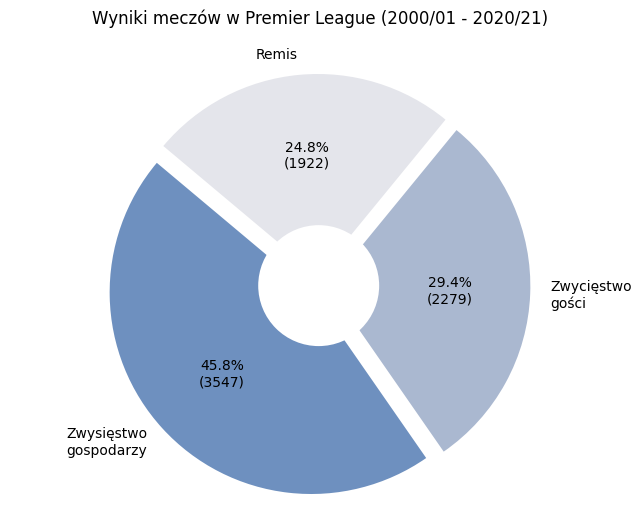

In [145]:
custom_labels = ['Zwysięstwo\ngospodarzy', 'Zwycięstwo\ngości', 'Remis']
explode = (0.05, 0.05, 0.05)

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(8, 6))
ftr_counts = df['FTR'].value_counts()
plt.pie(ftr_counts, explode=explode, labels=custom_labels, autopct=lambda pct: func(pct, ftr_counts), 
        startangle=140, colors=sns.color_palette('vlag'))
plt.title('Wyniki meczów w Premier League (2000/01 - 2020/21)\n')
plt.gca().add_artist(plt.Circle((0,0),0.3,fc='white'))
plt.axis('equal')
plt.show()

In [6]:
standings = pd.read_csv('C:/Users/kamil/OneDrive/Dokumenty/studia/magisterka/standings_2000_2022.csv')

standings['Season'] = standings['Season'].str[:4].astype('int64')
standings['Pos'] = standings['Pos'].astype('int64')
standings['Pts'] = standings['Pts'].astype('int64')

standings = standings[['Season', 'Pos', 'Team']]
standings = standings.rename(
    columns={'Season': 'season', 'Pos': 'position', 'Team': 'team'}
)

standings['team'] = standings['team'].replace('Manchester United', 'Man United')
standings['team'] = standings['team'].replace('Leeds United', 'Leeds')
standings['team'] = standings['team'].replace('Ipswich Town', 'Ipswich')
standings['team'] = standings['team'].replace('Charlton Athletic', 'Charlton')
standings['team'] = standings['team'].replace('Newcastle United', 'Newcastle')
standings['team'] = standings['team'].replace('Tottenham Hotspur', 'Tottenham')
standings['team'] = standings['team'].replace('Leicester City', 'Leicester')
standings['team'] = standings['team'].replace('West Ham United', 'West Ham')
standings['team'] = standings['team'].replace('Derby County', 'Derby')
standings['team'] = standings['team'].replace('Manchester City', 'Man City')
standings['team'] = standings['team'].replace('Coventry City', 'Coventry')
standings['team'] = standings['team'].replace('Bradford City', 'Bradford')
standings['team'] = standings['team'].replace('Blackburn Rovers', 'Blackburn')
standings['team'] = standings['team'].replace('Bolton Wanderers', 'Bolton')
standings['team'] = standings['team'].replace('Birmingham City', 'Birmingham')
standings['team'] = standings['team'].replace('West Bromwich Albion', 'West Brom')
standings['team'] = standings['team'].replace('Wolverhampton Wanderers', 'Wolves')
standings['team'] = standings['team'].replace('Norwich City', 'Norwich')
standings['team'] = standings['team'].replace('Wigan Athletic', 'Wigan')
standings['team'] = standings['team'].replace('Stoke City', 'Stoke')
standings['team'] = standings['team'].replace('Hull City', 'Hull')
standings['team'] = standings['team'].replace('Swansea City', 'Swansea')
standings['team'] = standings['team'].replace('Queens Park Rangers', 'QPR')
standings['team'] = standings['team'].replace('Cardiff City', 'Cardiff')
standings['team'] = standings['team'].replace('Brighton & Hove Albion', 'Brighton')
standings['team'] = standings['team'].replace('Huddersfield Town', 'Huddersfield')
standings['team'] = standings['team'].replace('Hull City', 'Hull')

standings

,season,position,team
0,2000,1,Man United
1,2000,2,Arsenal
2,2000,3,Liverpool
3,2000,4,Leeds
4,2000,5,Ipswich
...,...,...,...
435,2021,16,Everton
436,2021,17,Leeds
437,2021,18,Burnley
438,2021,19,Watford


In [7]:
unique_teams = pd.concat([df['home_team'], df['away_team']]).unique()
unique_teams

array(['Charlton', 'Chelsea', 'Coventry', 'Derby', 'Leeds', 'Leicester',
       'Liverpool', 'Sunderland', 'Tottenham', 'Man United', 'Arsenal',
       'Bradford', 'Ipswich', 'Middlesbrough', 'West Ham', 'Southampton',
       'Everton', 'Man City', 'Newcastle', 'Aston Villa', 'Bolton',
       'Blackburn', 'Fulham', 'West Brom', 'Birmingham', 'Portsmouth',
       'Wolves', 'Norwich', 'Crystal Palace', 'Wigan', 'Reading',
       'Sheffield United', 'Watford', 'Hull', 'Stoke', 'Burnley',
       'Blackpool', 'QPR', 'Swansea', 'Cardiff', 'Bournemouth',
       'Brighton', 'Huddersfield', 'Brentford'], dtype=object)

In [8]:
team_matches_dict = {}

for team in unique_teams:
    team_matches = df[df['home_team'].eq(team) | df['away_team'].eq(team)].copy()
    team_matches['team'] = team
    for index, row in team_matches.iterrows():
        if row['home_team'] == team:
            team_matches.at[index, 'opponent'] = row['away_team']
            team_matches.at[index, 'where'] = 'H'
            if row['FTR'] == 'H':
                team_matches.at[index, 'points'] = 3
            elif row['FTR'] == 'D':
                team_matches.at[index, 'points'] = 1
            elif row['FTR'] == 'A':
                team_matches.at[index, 'points'] = 0
            team_matches.at[index, 'GS'] = row['FTHG']
            team_matches.at[index, 'GC'] = row['FTAG']
            team_matches.at[index, 'S'] = row['HS']
            team_matches.at[index, 'OS'] = row['AS']
            team_matches.at[index, 'ST'] = row['HST']
            team_matches.at[index, 'OST'] = row['AST']
            team_matches.at[index, 'C'] = row['HC']
            team_matches.at[index, 'OC'] = row['AC']
        else:
            team_matches.at[index, 'opponent'] = row['home_team']
            team_matches.at[index, 'where'] = 'A'
            if row['FTR'] == 'H':
                team_matches.at[index, 'points'] = 0
            elif row['FTR'] == 'D':
                team_matches.at[index, 'points'] = 1
            elif row['FTR'] == 'A':
                team_matches.at[index, 'points'] = 3
            team_matches.at[index, 'GS'] = row['FTAG']
            team_matches.at[index, 'GC'] = row['FTHG']
            team_matches.at[index, 'S'] = row['AS']
            team_matches.at[index, 'OS'] = row['HS']
            team_matches.at[index, 'ST'] = row['AST']
            team_matches.at[index, 'OST'] = row['HST']
            team_matches.at[index, 'C'] = row['AC']
            team_matches.at[index, 'OC'] = row['HC']
    int_columns = ['points', 'GS', 'GC', 'S', 'OS', 'ST', 'OST', 'C', 'OC']
    team_matches[int_columns] = team_matches[int_columns].astype(int)
    team_matches = team_matches.drop(['home_team', 'away_team', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR'],axis=1)
    team_matches_dict[team] = team_matches

In [9]:
for team, matches_df in team_matches_dict.items():
    matches_df['LSP'] = None
    for season, season_df in matches_df.groupby('season'):
        prev_season = season - 1
        if prev_season in standings['season'].unique():
            prev_season_standings = standings[standings['season'] == prev_season]
            team_standings = prev_season_standings[prev_season_standings['team'] == team]
            if not team_standings.empty:
                prev_season_position = team_standings['position'].iloc[0]
                matches_df.loc[matches_df['season'] == season, 'LSP'] = prev_season_position

for team, matches_df in team_matches_dict.items():
    matches_df['LSP'] = matches_df['LSP'].fillna(21).astype(int)
    # 21 dla drużyn które w poprzednim sezonie awansowały do ligi
    
team_matches_dict.get('Man United')

,season,date_time,team,opponent,where,points,GS,GC,S,OS,ST,OST,C,OC,LSP
9,2000,2000-08-20,Man United,Newcastle,H,3,2,0,19,9,9,6,7,1,21
12,2000,2000-08-22,Man United,Ipswich,A,1,1,1,15,13,6,8,6,4,21
27,2000,2000-08-26,Man United,West Ham,A,1,2,2,8,17,5,8,5,7,21
32,2000,2000-09-05,Man United,Bradford,H,3,6,0,21,6,12,4,5,1,21
40,2000,2000-09-09,Man United,Sunderland,H,3,3,0,15,5,7,1,4,4,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8232,2021,2022-02-26,Man United,Watford,H,1,0,0,22,10,3,2,4,3,2
8245,2021,2022-03-06,Man United,Man City,A,0,1,4,5,24,2,10,3,9,2
8252,2021,2022-03-12,Man United,Tottenham,H,3,3,2,10,10,6,3,4,5,2
8268,2021,2022-04-02,Man United,Leicester,H,1,1,1,11,11,5,3,6,5,2


In [10]:
team_matches_dict = {team: matches_df[matches_df['season'] != 2000] 
                     for team, matches_df in team_matches_dict.items()}

team_matches_dict.get('Man United')

,season,date_time,team,opponent,where,points,GS,GC,S,OS,ST,OST,C,OC,LSP
389,2001,2001-08-19,Man United,Fulham,H,3,3,2,12,8,6,5,6,4,1
394,2001,2001-08-22,Man United,Blackburn,A,1,2,2,18,12,7,5,8,3,1
403,2001,2001-08-26,Man United,Aston Villa,A,1,1,1,13,11,7,4,5,5,1
412,2001,2001-09-08,Man United,Everton,H,3,4,1,18,5,9,1,6,2,1
421,2001,2001-09-15,Man United,Newcastle,A,0,3,4,10,15,7,8,5,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8232,2021,2022-02-26,Man United,Watford,H,1,0,0,22,10,3,2,4,3,2
8245,2021,2022-03-06,Man United,Man City,A,0,1,4,5,24,2,10,3,9,2
8252,2021,2022-03-12,Man United,Tottenham,H,3,3,2,10,10,6,3,4,5,2
8268,2021,2022-04-02,Man United,Leicester,H,1,1,1,11,11,5,3,6,5,2


In [11]:
def rolling_averages(team, cols, new_cols, number_of_games):
    team_df = team_matches_dict.get(team).sort_values('date_time')
    rolling_stats = team_df[cols].rolling(number_of_games, closed='left').mean()
    team_df[new_cols] = rolling_stats.values
    team_matches_dict[team] = team_df

    
cols = ['points', 'GS', 'GC', 'S', 'OS', 'ST', 'OST', 'C', 'OC']
new_cols = [f'{c}_rolling' for c in cols]

for team in unique_teams:
    rolling_averages(team, cols, new_cols, 5)

In [12]:
team_matches_dict.get('Man United').tail()

,season,date_time,team,opponent,where,points,GS,GC,S,OS,...,LSP,points_rolling,GS_rolling,GC_rolling,S_rolling,OS_rolling,ST_rolling,OST_rolling,C_rolling,OC_rolling
8232,2021,2022-02-26,Man United,Watford,H,1,0,0,22,10,...,2,2.2,1.8,0.8,17.2,10.8,6.4,3.4,5.4,2.8
8245,2021,2022-03-06,Man United,Man City,A,0,1,4,5,24,...,2,1.8,1.6,0.8,18.0,11.6,6.4,3.6,5.6,2.8
8252,2021,2022-03-12,Man United,Tottenham,H,3,3,2,10,10,...,2,1.6,1.6,1.4,14.6,14.6,5.8,5.0,4.2,4.2
8268,2021,2022-04-02,Man United,Leicester,H,1,1,1,11,11,...,2,2.0,2.0,1.6,14.2,14.0,5.4,4.8,4.8,4.4
8283,2021,2022-04-09,Man United,Everton,A,0,0,1,12,7,...,2,1.6,1.8,1.8,12.6,14.2,5.0,4.8,4.0,5.0


In [13]:
df = df[df['season'] != 2000]

cols = ['points_rolling', 'GS_rolling', 'GC_rolling', 'S_rolling', 
        'OS_rolling', 'ST_rolling', 'OST_rolling', 'C_rolling', 'OC_rolling', 'LSP']

new_cols_home = [f'home_team_{c}' for c in cols]
new_cols_away = [f'away_team_{c}' for c in cols]

for index, row in df.iterrows():
    for i in range(len(cols)):
        df.at[index, new_cols_home[i]] = team_matches_dict.get(row['home_team'])[cols[i]].loc[index]
        df.at[index, new_cols_away[i]] = team_matches_dict.get(row['away_team'])[cols[i]].loc[index]
    
df.dropna(axis=0, how='any', inplace=True)

df['home_team_LSP'] = df['home_team_LSP'].astype('int64')
df['away_team_LSP'] = df['away_team_LSP'].astype('int64')

df.head()


,season,date_time,home_team,away_team,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,home_team_ST_rolling,away_team_ST_rolling,home_team_OST_rolling,away_team_OST_rolling,home_team_C_rolling,away_team_C_rolling,home_team_OC_rolling,away_team_OC_rolling,home_team_LSP,away_team_LSP
427,2001,2001-09-19,Blackburn,Bolton,1,1,D,0,0,D,...,4.8,3.8,5.8,4.8,7.8,4.4,5.6,4.0,21,21
428,2001,2001-09-19,Sunderland,Tottenham,1,2,A,0,1,A,...,3.6,3.8,4.4,6.0,4.2,4.2,7.8,5.0,7,12
430,2001,2001-09-22,Man United,Ipswich,4,0,H,2,0,H,...,7.2,10.4,4.6,5.0,6.0,7.0,4.4,4.6,1,5
432,2001,2001-09-22,Blackburn,Everton,1,0,H,1,0,H,...,5.6,6.2,6.2,5.0,7.8,4.2,5.2,3.6,21,16
433,2001,2001-09-22,Arsenal,Bolton,1,1,D,0,0,D,...,8.4,3.2,2.4,6.2,7.2,3.8,2.6,5.4,2,21


In [14]:
df['home_team_code'] = df['home_team'].astype('category').cat.codes
df['away_team_code'] = df['away_team'].astype('category').cat.codes

cols = ['points', 'GS', 'GC', 'S', 'OS', 'ST', 'OST', 'C', 'OC']
for col in cols:
    df[f'{col}_difference'] = df[f'home_team_{col}_rolling'] - df[f'away_team_{col}_rolling']
    
df['LSP_difference'] = df[f'home_team_LSP'] - df[f'away_team_LSP']
    
df['target'] = df['FTR'].map({'H': 0, 'D': 1, 'A': 2})

df.head()

,season,date_time,home_team,away_team,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,GS_difference,GC_difference,S_difference,OS_difference,ST_difference,OST_difference,C_difference,OC_difference,LSP_difference,target
427,2001,2001-09-19,Blackburn,Bolton,1,1,D,0,0,D,...,-0.4,1.0,0.0,2.4,1.0,1.0,3.4,1.6,0,1
428,2001,2001-09-19,Sunderland,Tottenham,1,2,A,0,1,A,...,-0.6,-0.6,-3.0,-1.0,-0.2,-1.6,0.0,2.8,-5,2
430,2001,2001-09-22,Man United,Ipswich,4,0,H,2,0,H,...,1.6,1.0,-3.8,1.2,-3.2,-0.4,-1.0,-0.2,-4,0
432,2001,2001-09-22,Blackburn,Everton,1,0,H,1,0,H,...,-0.2,-0.6,1.4,4.0,-0.6,1.2,3.6,1.6,5,0
433,2001,2001-09-22,Arsenal,Bolton,1,1,D,0,0,D,...,1.8,0.2,5.4,-8.2,5.2,-3.8,3.4,-2.8,-19,1


In [150]:
train = df[(df['season'] >= 2010) & (df['season'] <= 2015)]

train

,season,date_time,home_team,away_team,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,GS_difference,GC_difference,S_difference,OS_difference,ST_difference,OST_difference,C_difference,OC_difference,LSP_difference,target
3800,2010,2010-08-14,Wolves,Stoke,2,1,H,2,0,H,...,0.4,-1.6,5.2,-5.6,2.6,-5.6,3.4,-1.6,4,0
3802,2010,2010-08-14,Tottenham,Man City,0,0,D,0,0,D,...,0.6,0.8,5.0,1.4,2.4,2.2,1.6,0.6,-1,1
3803,2010,2010-08-14,Sunderland,Birmingham,2,2,D,1,0,H,...,0.0,-0.8,0.4,-0.6,-0.6,0.2,-0.6,-2.2,4,1
3804,2010,2010-08-14,Aston Villa,West Ham,3,0,H,2,0,H,...,-0.2,-0.8,3.0,2.4,2.0,3.4,4.6,1.6,-11,0
3805,2010,2010-08-14,Bolton,Fulham,0,0,D,0,0,D,...,0.4,-0.6,3.6,5.8,2.8,1.6,-0.4,0.6,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,2015,2016-05-15,Stoke,West Ham,2,1,H,0,1,A,...,-1.8,1.2,-6.2,7.0,-3.0,1.6,-3.4,3.0,-3,0
6076,2015,2016-05-15,Swansea,Man City,1,1,D,1,1,D,...,-0.8,0.4,2.4,5.0,-0.8,2.0,-0.6,1.2,6,1
6077,2015,2016-05-15,Watford,Sunderland,2,2,D,0,1,A,...,-0.6,1.6,-0.2,0.4,0.2,-1.2,-0.2,-0.2,5,1
6078,2015,2016-05-15,West Brom,Liverpool,1,1,D,1,1,D,...,-1.6,0.4,-8.2,2.4,-3.4,-0.2,-0.6,1.0,7,1


In [151]:
test = df[df['season'] == 2016]

test

,season,date_time,home_team,away_team,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,GS_difference,GC_difference,S_difference,OS_difference,ST_difference,OST_difference,C_difference,OC_difference,LSP_difference,target
6080,2016,2016-08-13,Middlesbrough,Stoke,1,1,D,1,0,H,...,-0.2,-0.4,-0.4,-3.2,2.4,2.0,-0.4,0.0,12,1
6081,2016,2016-08-13,Southampton,Watford,1,1,D,0,1,A,...,1.4,-1.2,1.0,-0.6,-0.2,0.0,1.4,0.2,-7,1
6082,2016,2016-08-13,Man City,Sunderland,2,1,H,1,0,H,...,0.2,0.6,-0.6,-7.2,0.0,-3.0,-0.4,-0.2,-13,0
6083,2016,2016-08-13,Everton,Tottenham,1,1,D,1,0,H,...,-0.6,0.2,-7.8,7.8,0.0,2.2,-4.2,3.6,8,1
6084,2016,2016-08-13,Crystal Palace,West Brom,0,1,A,0,0,D,...,0.2,0.2,-2.0,3.0,-0.2,1.6,-1.4,0.4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6455,2016,2017-05-21,Leicester,Bournemouth,1,1,D,0,1,A,...,-0.6,0.4,-5.0,2.2,-1.6,1.2,1.4,0.2,-15,1
6456,2016,2017-05-21,Hull,Tottenham,1,7,A,0,3,A,...,-1.6,1.2,-6.6,2.2,-5.2,0.0,-2.6,1.2,18,2
6457,2016,2017-05-21,Chelsea,Sunderland,5,1,H,1,1,D,...,2.6,-0.2,7.8,-6.8,2.6,-3.4,1.6,-3.6,-7,0
6458,2016,2017-05-21,Burnley,West Ham,1,2,A,1,1,D,...,0.6,0.6,0.2,2.2,-0.4,0.6,0.2,1.6,14,2


In [146]:
predictors = [
    'home_team_code', 
    'away_team_code',
    'home_team_LSP',
    'away_team_LSP',
    'home_team_GS_rolling',
    'away_team_GS_rolling',
    'home_team_GC_rolling',
    'away_team_GC_rolling',
    'home_team_S_rolling', 
    'away_team_S_rolling', 
    'home_team_OS_rolling',
    'away_team_OS_rolling', 
    'home_team_ST_rolling', 
    'away_team_ST_rolling', 
    'home_team_OST_rolling', 
    'away_team_OST_rolling', 
    'home_team_C_rolling', 
    'away_team_C_rolling', 
    'home_team_OC_rolling', 
    'away_team_OC_rolling',
    'home_team_points_rolling',
    'away_team_points_rolling',
    'points_difference', 
    'GS_difference', 
    'GC_difference', 
    'S_difference', 
    'OS_difference', 
    'ST_difference', 
    'OST_difference', 
    'C_difference', 
    'OC_difference'
]

X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

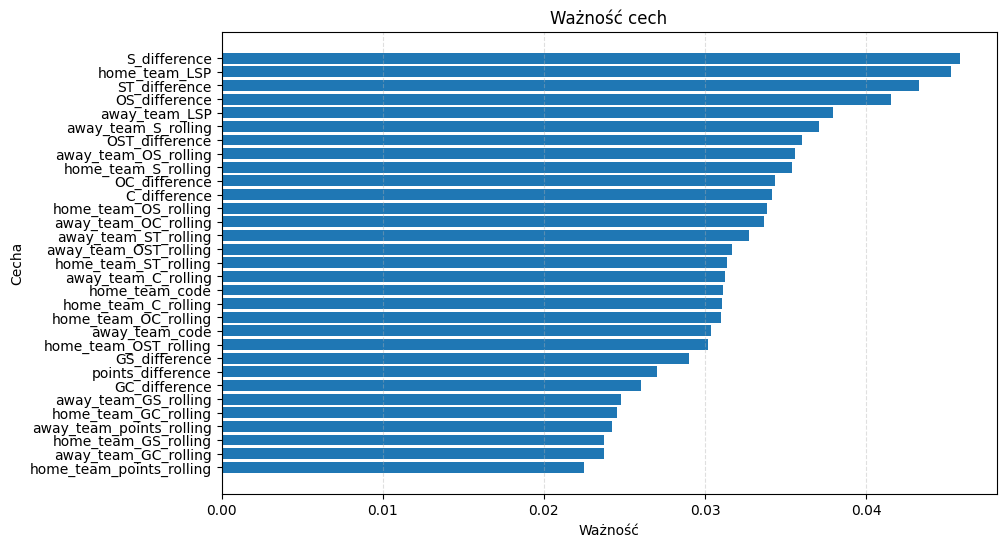

In [147]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Ważność')
plt.ylabel('Cecha')
plt.title('Ważność cech')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.xlim(0)
plt.show()

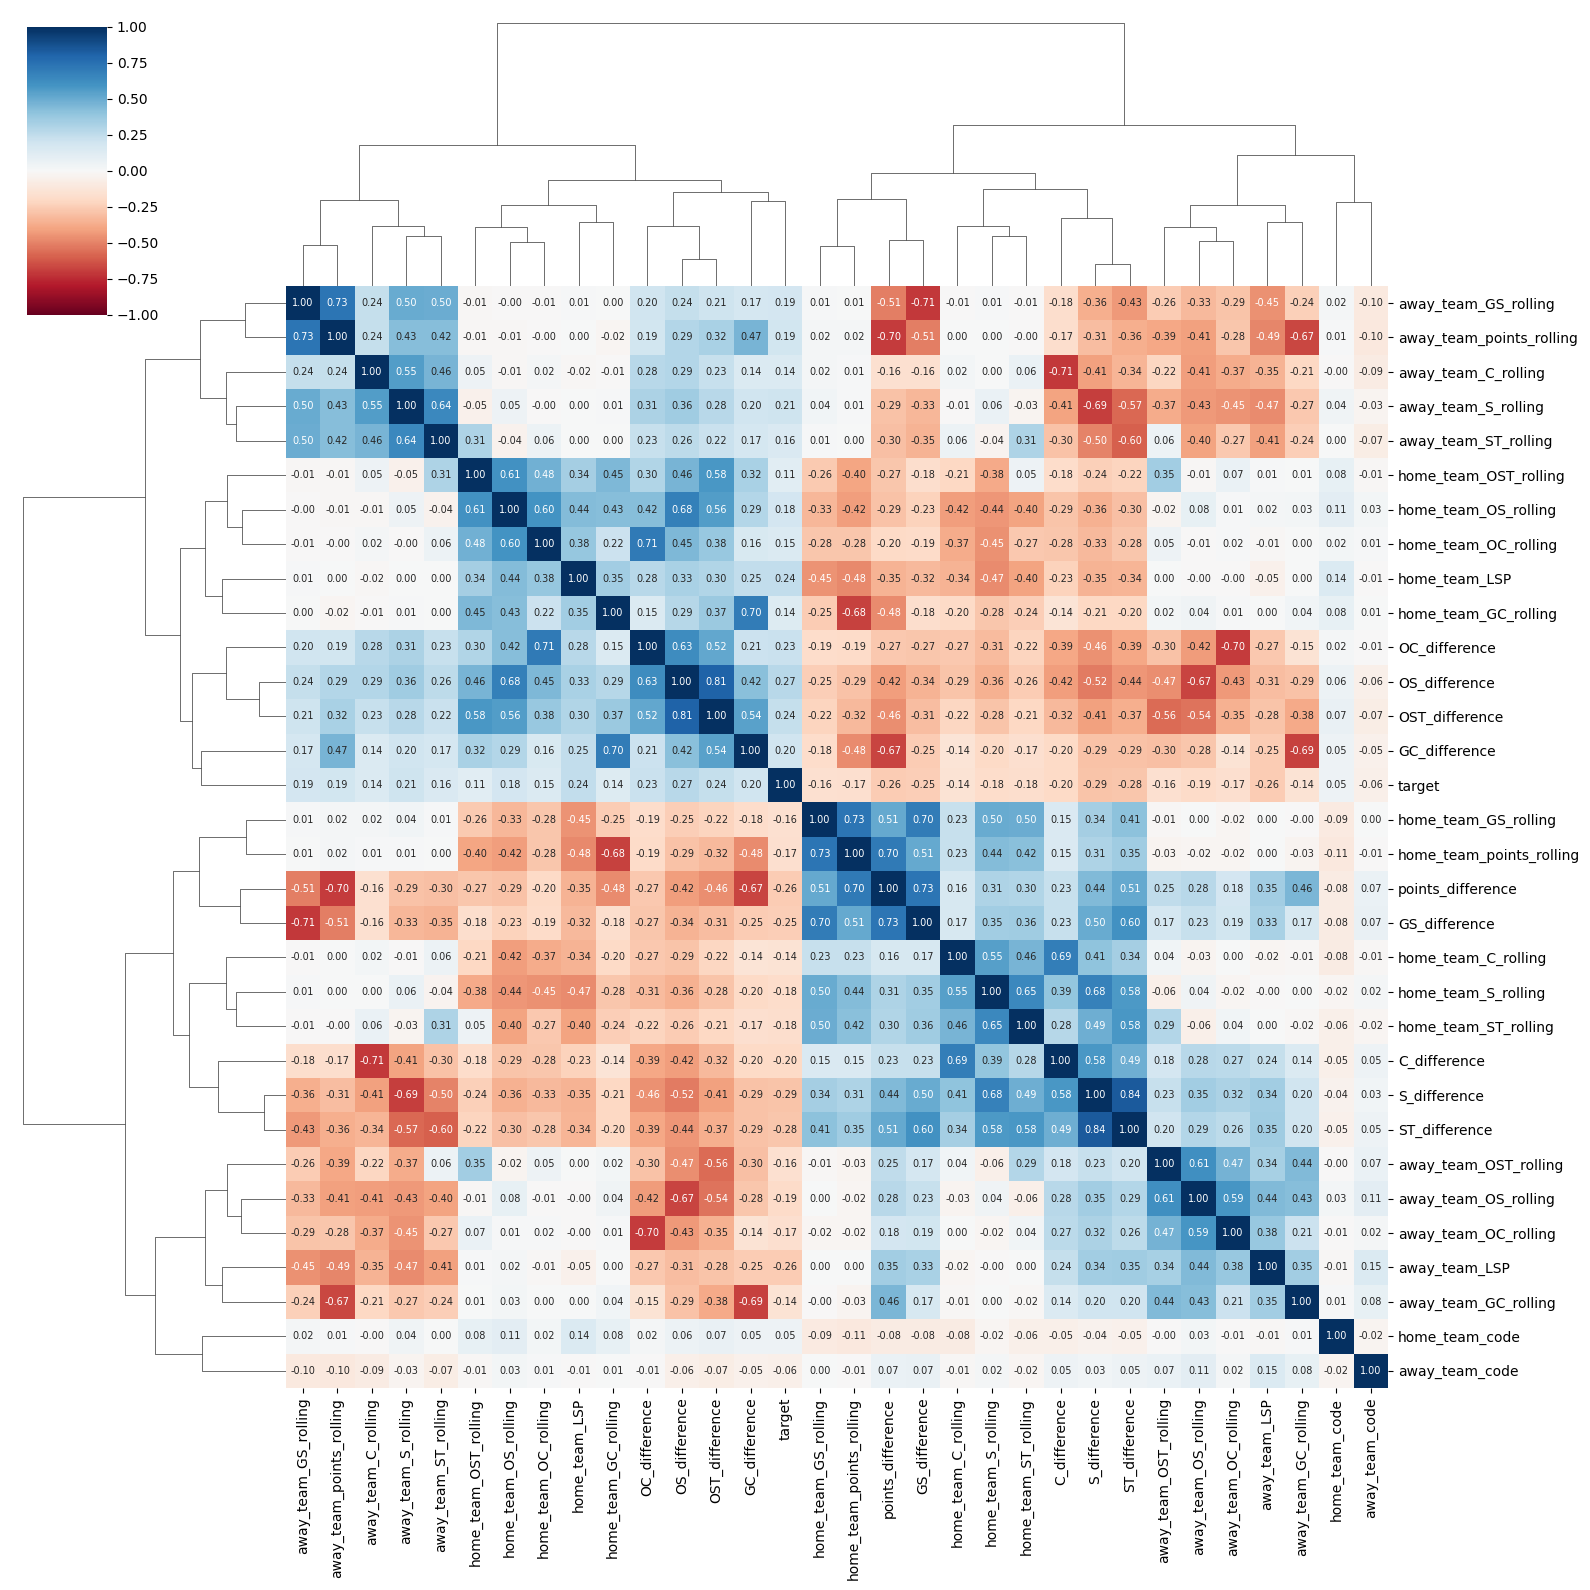

In [19]:
corr_matrix = df[predictors + ['target']].corr()

sns.clustermap(corr_matrix, method='complete', annot=True, cmap='RdBu', 
               fmt=".2f", annot_kws={"fontsize": 7}, vmin=-1, vmax=1, figsize=(16, 16))

In [152]:
predictors = [
    'home_team_LSP',
    'away_team_LSP',
    'home_team_code',
    'away_team_code',
    'GS_difference',
    'GC_difference',
    'ST_difference',
    'OS_difference'
]

X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

Best accuracy: 0.59; n=51


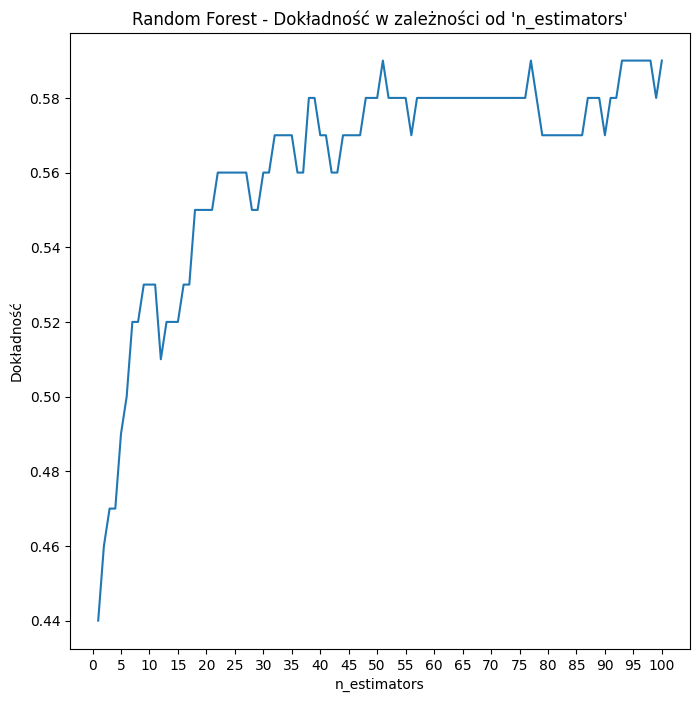

In [153]:
plot_scores_rf = []

for n_estimators in range(1, 101):
    clf_rf = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=10, random_state=1)
    clf_rf.fit(X_train,y_train)
    test_preds = clf_rf.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_rf.append(score)
 
plt.figure(figsize = (8, 8))
plt.plot(range(1, 101), plot_scores_rf)
plt.title("Random Forest - Dokładność w zależności od 'n_estimators'")
plt.xlabel('n_estimators')
plt.ylabel('Dokładność')
plt.xticks(range(0, 101, 5))

best_accuracy = max(plot_scores_rf)
best_n_rf = plot_scores_rf.index(best_accuracy)+1
print(f'Best accuracy: {best_accuracy}; n={best_n_rf}')

In [22]:
rf = RandomForestClassifier(n_estimators=best_n_rf, min_samples_split=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=51, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.63      0.79      0.70       187
                Remis       0.46      0.15      0.23        84
     Zwycięstwo gości       0.54      0.59      0.56       109

             accuracy                           0.59       380
            macro avg       0.54      0.51      0.50       380
         weighted avg       0.57      0.59      0.56       380



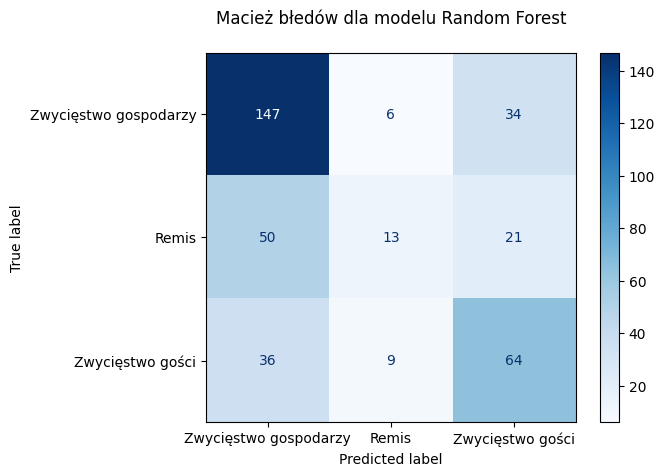

In [23]:
rf_test_preds = rf.predict(X_test)

report = classification_report(y_test, rf_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, rf_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macież błedów dla modelu Random Forest\n')
plt.show()

In [24]:
rf_train_preds = rf.predict(X_train)

rf_train_accuracy = accuracy_score(y_train, rf_train_preds)
print(f'Random Forest Train Accuracy: {rf_train_accuracy:.2f}')

Random Forest Train Accuracy: 0.90


***
Próba zbalansowania zbioru treningowego (oversampling)

In [25]:
class_counts = train['FTR'].value_counts()

print(class_counts)

FTR
H    1014
A     658
D     583
Name: count, dtype: int64


In [26]:
class_counts = train['FTR'].value_counts()
majority_class = class_counts.idxmax()

balanced_train_over = pd.concat([
    resample(train[train['FTR'] == cls], 
             replace=True,
             n_samples=class_counts[majority_class],
             random_state=42)
    for cls in class_counts.index
])

print(balanced_train_over['FTR'].value_counts())

FTR
H    1014
A    1014
D    1014
Name: count, dtype: int64


In [27]:
X_train = balanced_train_over[predictors]
y_train = balanced_train_over['target']

X_test = test[predictors]
y_test = test['target']

In [28]:
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=51, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.66      0.56      0.60       187
                Remis       0.34      0.32      0.33        84
     Zwycięstwo gości       0.45      0.60      0.51       109

             accuracy                           0.52       380
            macro avg       0.49      0.49      0.48       380
         weighted avg       0.53      0.52      0.52       380



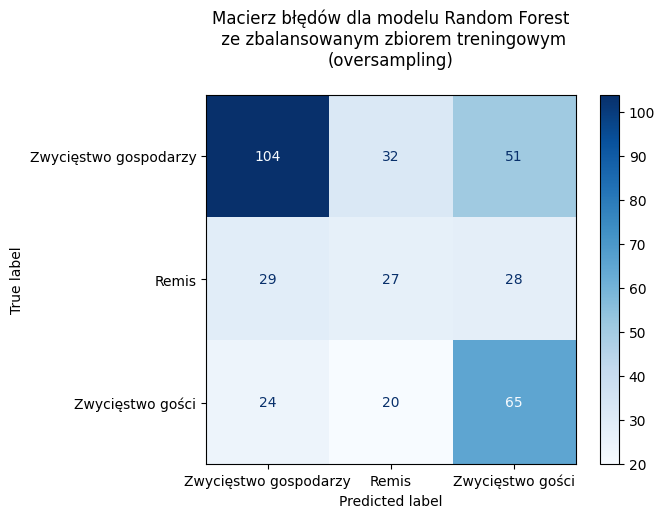

In [29]:
rf2_test_preds = rf.predict(X_test)

report = classification_report(y_test, rf2_test_preds,
                              target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, rf2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Random Forest\n ze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

***
Próba zbalansowanie zbioru treningowego (undersampling)

In [30]:
class_counts = train['FTR'].value_counts()
minority_class = class_counts.idxmin()

balanced_train_under = pd.concat([
    resample(train[train['FTR'] == cls], 
             replace=False,
             n_samples=class_counts[minority_class],
             random_state=42)
    for cls in class_counts.index
])

print(balanced_train_under['FTR'].value_counts())


FTR
H    583
A    583
D    583
Name: count, dtype: int64


In [31]:
X_train = balanced_train_under[predictors]
y_train = balanced_train_under['target']

X_test = test[predictors]
y_test = test['target']

In [32]:
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=51, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.62      0.45      0.53       187
                Remis       0.22      0.27      0.24        84
     Zwycięstwo gości       0.44      0.56      0.49       109

             accuracy                           0.44       380
            macro avg       0.43      0.43      0.42       380
         weighted avg       0.48      0.44      0.45       380



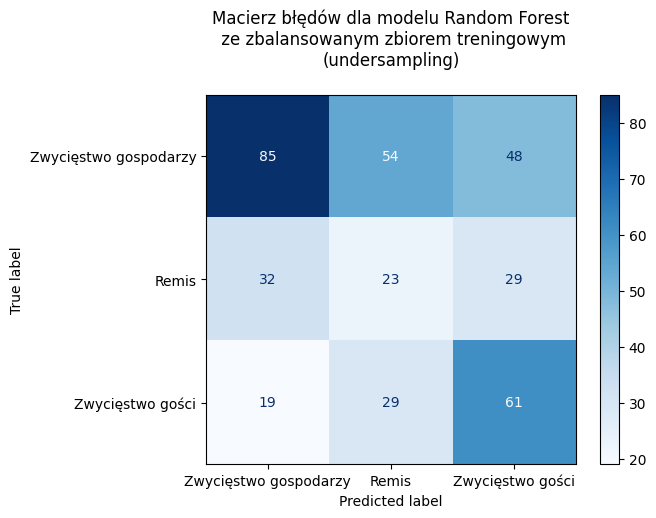

In [33]:
rf3_test_preds = rf.predict(X_test)

report = classification_report(y_test, rf3_test_preds,
                              target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, rf3_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Random Forest\n ze zbalansowanym zbiorem treningowym\n(undersampling)\n')
plt.show()

In [34]:
X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

Best accuracy: 0.58; n=66


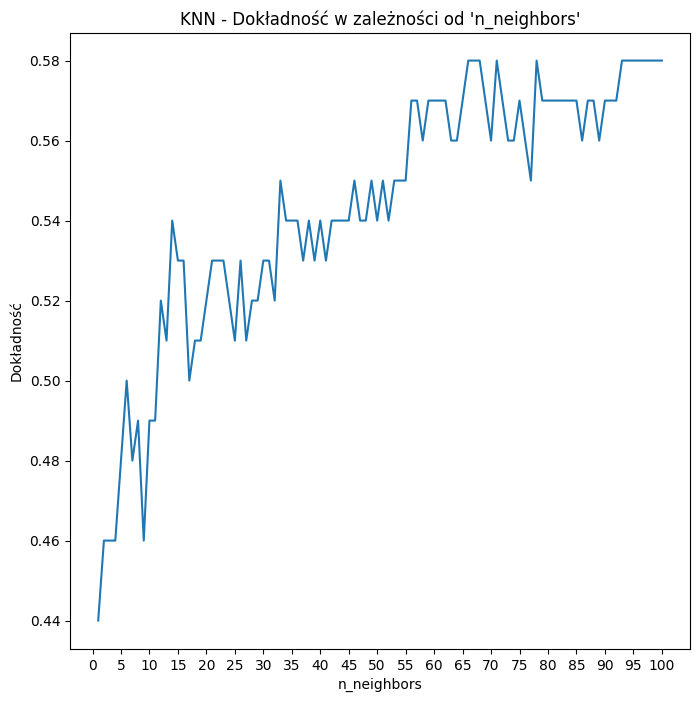

In [35]:
plot_scores_knn = []

for n_neighbors in range(1, 101):
    clf_knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf_knn.fit(X_train,y_train)
    test_preds = clf_knn.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_knn.append(score)
 
plt.figure(figsize = (8, 8))
plt.plot(range(1, 101),plot_scores_knn)
plt.title("KNN - Dokładność w zależności od 'n_neighbors'")
plt.xlabel('n_neighbors')
plt.ylabel('Dokładność')
plt.xticks(range(0, 101, 5))

best_accuracy = max(plot_scores_knn)
best_n_knn = plot_scores_knn.index(best_accuracy)+1
print(f'Best accuracy: {best_accuracy}; n={best_n_knn}')

In [36]:
knn = KNeighborsClassifier(n_neighbors=best_n_knn)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=66)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.61      0.84      0.71       187
                Remis       0.20      0.04      0.06        84
     Zwycięstwo gości       0.54      0.54      0.54       109

             accuracy                           0.58       380
            macro avg       0.45      0.47      0.44       380
         weighted avg       0.50      0.58      0.52       380



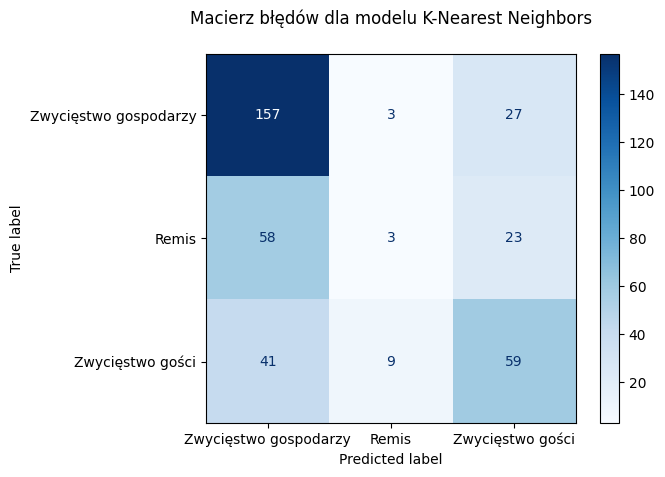

In [37]:
knn_test_preds = knn.predict(X_test)

report = classification_report(y_test, knn_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości']
)

print(report)

conf_matrix = confusion_matrix(y_test, knn_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu K-Nearest Neighbors\n')
plt.show()

In [38]:
knn_train_preds = knn.predict(X_train)

knn_train_accuracy = accuracy_score(y_train, knn_train_preds)
print(f'KNN Train accuracy: {knn_train_accuracy:.2f}')

KNN Train accuracy: 0.53


***
Próba wykorzystania zbalansowanego zbioru treningowego

In [39]:
X_train = balanced_train_over[predictors]
y_train = balanced_train_over['target']

X_test = test[predictors]
y_test = test['target']

In [40]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=66)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.61      0.48      0.53       187
                Remis       0.17      0.20      0.18        84
     Zwycięstwo gości       0.48      0.57      0.52       109

             accuracy                           0.44       380
            macro avg       0.42      0.42      0.41       380
         weighted avg       0.47      0.44      0.45       380



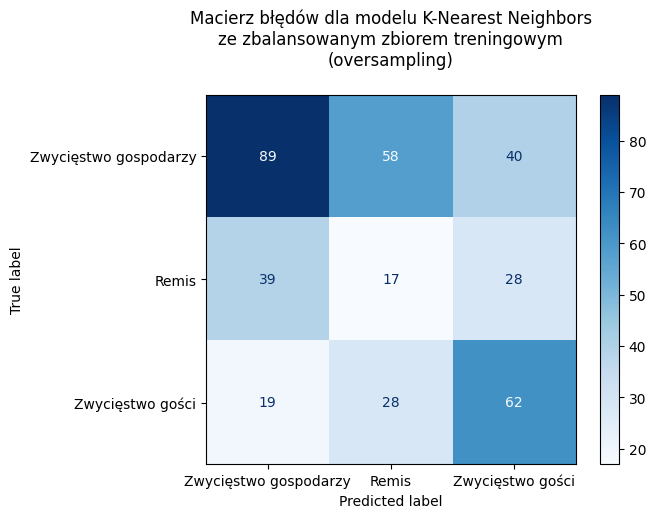

In [41]:
knn2_test_preds = knn.predict(X_test)

report = classification_report(y_test, knn2_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, knn2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu K-Nearest Neighbors\nze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [42]:
X_train = balanced_train_under[predictors]
y_train = balanced_train_under['target']

X_test = test[predictors]
y_test = test['target']

In [43]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=66)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.66      0.49      0.56       187
                Remis       0.18      0.23      0.20        84
     Zwycięstwo gości       0.49      0.61      0.54       109

             accuracy                           0.47       380
            macro avg       0.44      0.44      0.44       380
         weighted avg       0.51      0.47      0.48       380



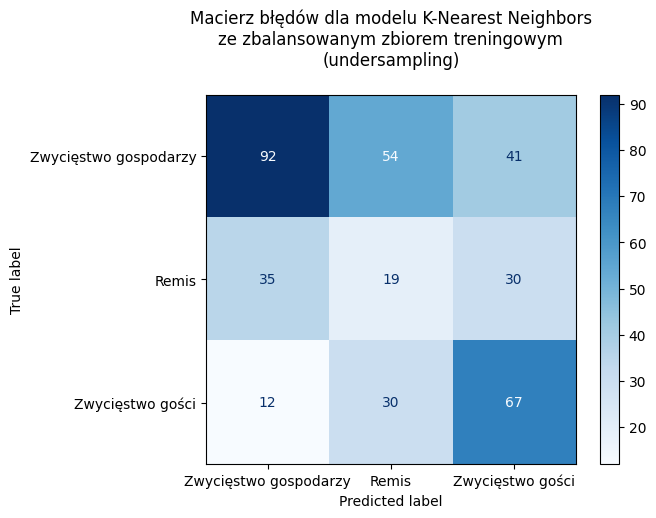

In [44]:
knn3_test_preds = knn.predict(X_test)

report = classification_report(y_test, knn3_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, knn3_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu K-Nearest Neighbors\nze zbalansowanym zbiorem treningowym\n(undersampling)\n')
plt.show()

In [45]:
X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

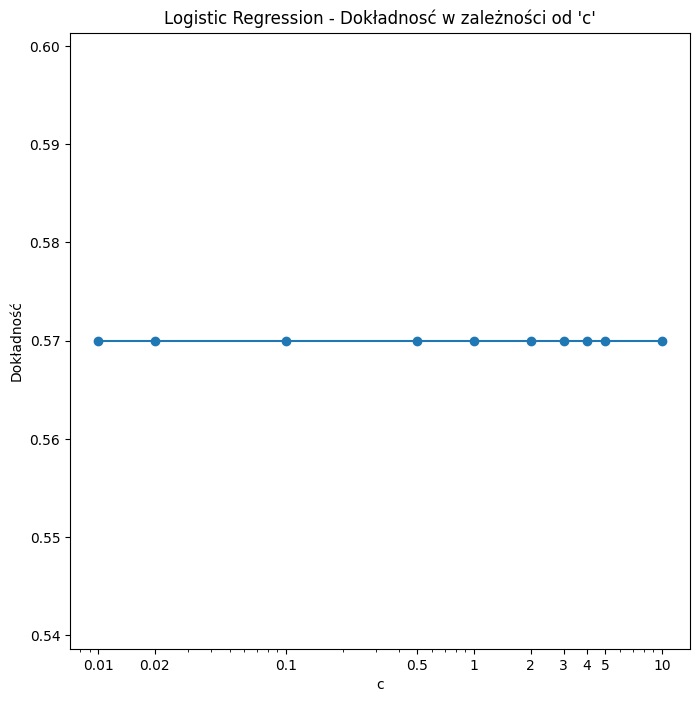

Best accuracy: 0.57; c=0.01


In [46]:
plot_scores_lr = []

cs = [0.01, 0.02, 0.1, 0.5, 1, 2, 3, 4, 5, 10]

for c in cs:
    lr = LogisticRegression(C=c, solver='lbfgs', multi_class='multinomial', max_iter=1000, random_state=1)
    lr.fit(X_train, y_train)
    test_preds = lr.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_lr.append(score)
 
plt.figure(figsize=(8, 8))
plt.plot(cs, plot_scores_lr, marker='o')
plt.title("Logistic Regression - Dokładnosć w zależności od 'c'")
plt.xlabel("c")
plt.ylabel('Dokładność')
plt.xscale('log')
plt.xticks(cs, cs)
plt.show()

best_accuracy = max(plot_scores_lr)
best_c_lr = cs[plot_scores_lr.index(best_accuracy)]
print(f'Best accuracy: {best_accuracy}; c={best_c_lr}')

In [47]:
lr = LogisticRegression(C=best_c_lr, solver='lbfgs', multi_class='multinomial', 
                        max_iter=1000, random_state=1)
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=1000, multi_class='multinomial',
                   random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.59      0.81      0.68       187
                Remis       0.00      0.00      0.00        84
     Zwycięstwo gości       0.53      0.61      0.57       109

             accuracy                           0.57       380
            macro avg       0.37      0.47      0.42       380
         weighted avg       0.44      0.57      0.50       380



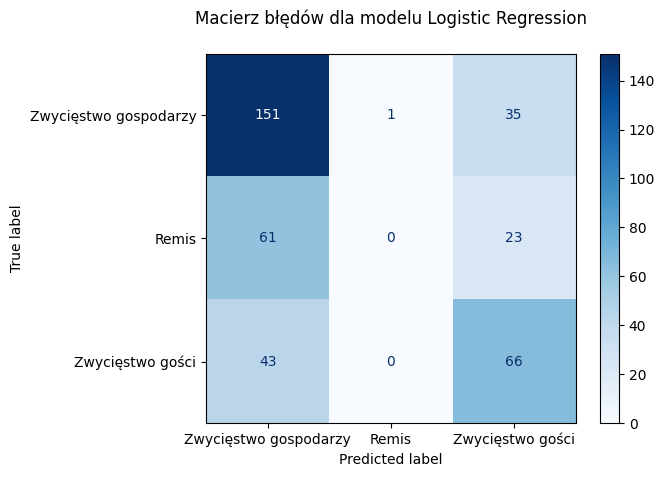

In [48]:
lr_test_preds = lr.predict(X_test)

report = classification_report(y_test, lr_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, lr_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Logistic Regression\n')
plt.show()

In [49]:
lr_train_preds = lr.predict(X_train)

lr_train_accuracy = accuracy_score(y_train, lr_train_preds)
print(f'Logistic Regression Train accuracy: {lr_train_accuracy:.2f}')

Logistic Regression Train accuracy: 0.52


***
Próba wykorzystania zbalansowanego zbioru treningowego

In [50]:
X_train = balanced_train_over[predictors]
y_train = balanced_train_over['target']

X_test = test[predictors]
y_test = test['target']

In [51]:
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=1000, multi_class='multinomial',
                   random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.64      0.55      0.59       187
                Remis       0.27      0.24      0.25        84
     Zwycięstwo gości       0.51      0.68      0.58       109

             accuracy                           0.52       380
            macro avg       0.47      0.49      0.48       380
         weighted avg       0.52      0.52      0.51       380



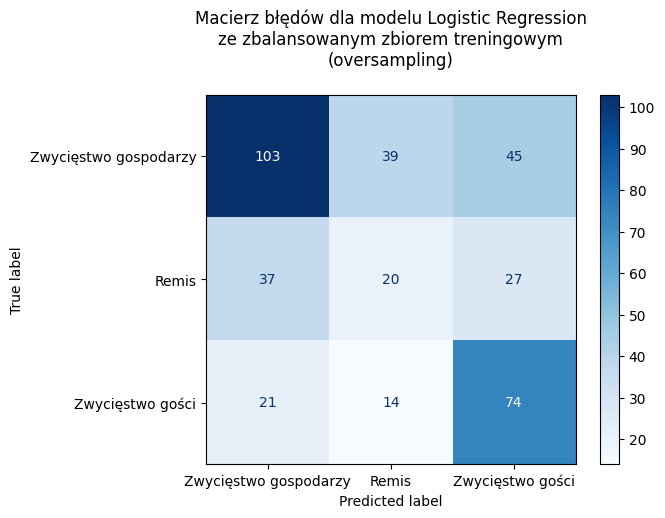

In [52]:
lr2_test_preds = lr.predict(X_test)

report = classification_report(y_test, lr2_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, lr2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Logistic Regression\nze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [53]:
X_train = balanced_train_under[predictors]
y_train = balanced_train_under['target']

X_test = test[predictors]
y_test = test['target']

In [54]:
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=1000, multi_class='multinomial',
                   random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.63      0.58      0.60       187
                Remis       0.25      0.19      0.22        84
     Zwycięstwo gości       0.50      0.67      0.57       109

             accuracy                           0.52       380
            macro avg       0.46      0.48      0.46       380
         weighted avg       0.51      0.52      0.51       380



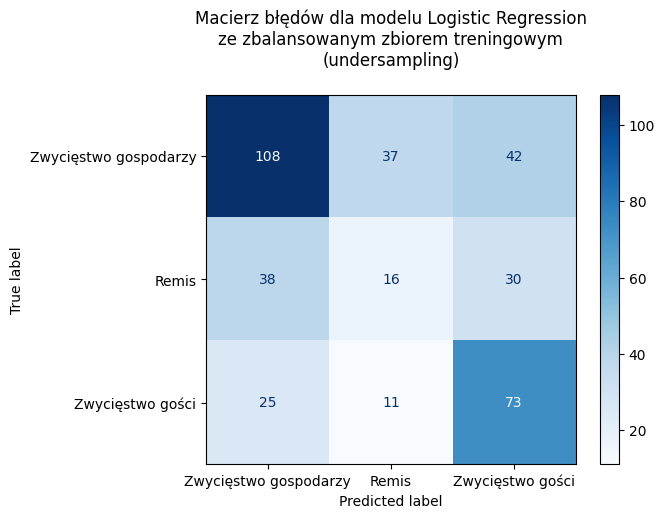

In [55]:
lr3_test_preds = lr.predict(X_test)

report = classification_report(y_test, lr3_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, lr3_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Logistic Regression\nze zbalansowanym zbiorem treningowym\n(undersampling)\n')
plt.show()

In [56]:
X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

Best accuracy: 0.52; n=3


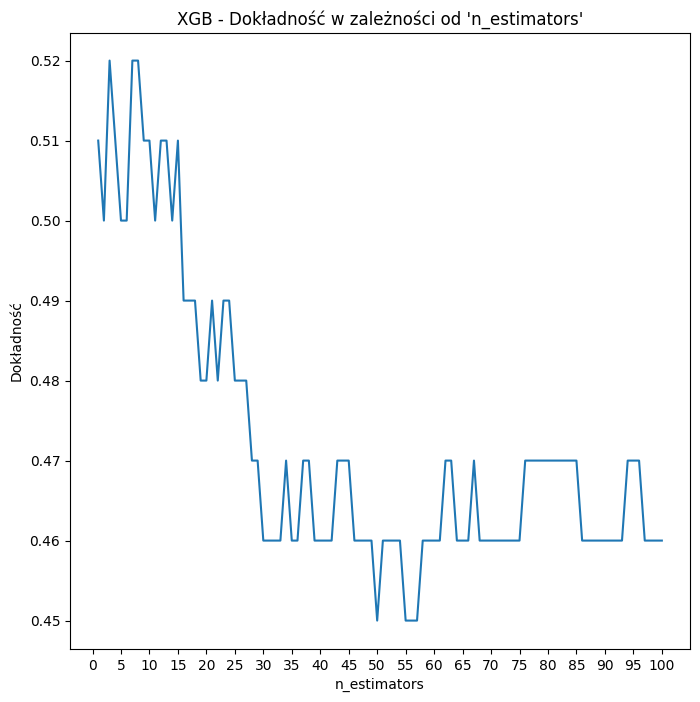

In [57]:
plot_scores_xgb = []

for n in range(1, 101):
    xgb = XGBClassifier(n_estimators=n, min_samples_split=10, random_state=1)
    xgb.fit(X_train,y_train)
    test_preds = xgb.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_xgb.append(score)
 
plt.figure(figsize = (8, 8))
plt.plot(range(1, 101), plot_scores_xgb)
plt.title("XGB - Dokładność w zależności od 'n_estimators'")
plt.xlabel('n_estimators')
plt.ylabel('Dokładność')
plt.xticks(range(0, 101, 5))

best_accuracy = max(plot_scores_xgb)
best_n_xgb = plot_scores_xgb.index(best_accuracy)+1
print(f'Best accuracy: {best_accuracy}; n={best_n_xgb}')

In [58]:
xgb = XGBClassifier(n_estimators=best_n_xgb, min_samples_split=10, random_state=1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, min_samples_split=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3,
              n_jobs=None, num_parallel_tree=None, ...)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.58      0.68      0.63       187
                Remis       0.25      0.07      0.11        84
     Zwycięstwo gości       0.47      0.59      0.52       109

             accuracy                           0.52       380
            macro avg       0.43      0.45      0.42       380
         weighted avg       0.48      0.52      0.48       380



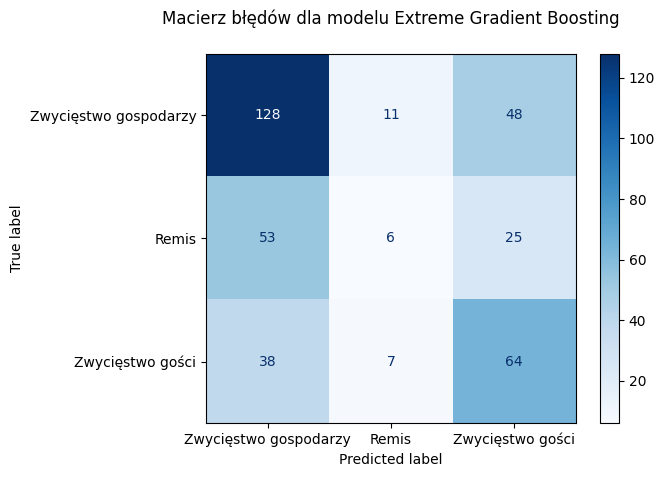

In [59]:
xgb_test_preds = xgb.predict(X_test)

report = classification_report(y_test, xgb_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, xgb_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Extreme Gradient Boosting\n')
plt.show()

In [60]:
xgb_train_preds = xgb.predict(X_train)

xgb_train_accuracy = accuracy_score(y_train, xgb_train_preds)
print(f'XGB Train accuracy: {xgb_train_accuracy:.2f}')

XGB Train accuracy: 0.63


***
Próba zastosowania zbalansowanego zbioru treningowego

In [61]:
X_train = balanced_train_over[predictors]
y_train = balanced_train_over['target']

X_test = test[predictors]
y_test = test['target']

In [62]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, min_samples_split=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3,
              n_jobs=None, num_parallel_tree=None, ...)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.58      0.44      0.50       187
                Remis       0.26      0.36      0.30        84
     Zwycięstwo gości       0.42      0.48      0.45       109

             accuracy                           0.43       380
            macro avg       0.42      0.42      0.42       380
         weighted avg       0.46      0.43      0.44       380



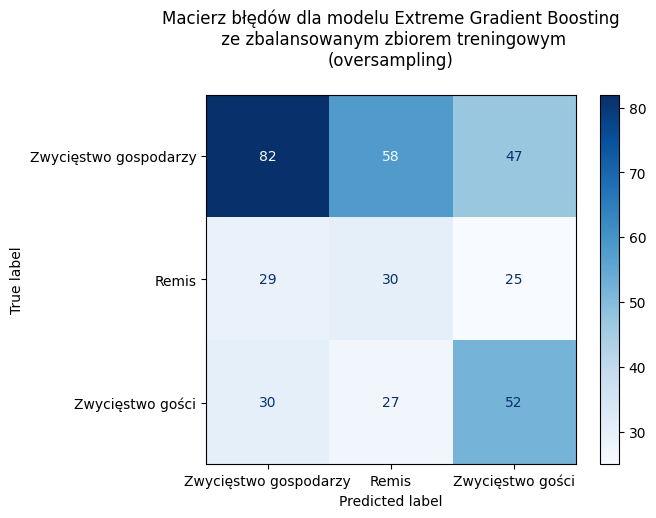

In [63]:
xgb2_test_preds = xgb.predict(X_test)

report = classification_report(y_test, xgb2_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, xgb2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Extreme Gradient Boosting\n ze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [64]:
X_train = balanced_train_under[predictors]
y_train = balanced_train_under['target']

X_test = test[predictors]
y_test = test['target']

In [65]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, min_samples_split=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3,
              n_jobs=None, num_parallel_tree=None, ...)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.63      0.40      0.49       187
                Remis       0.25      0.38      0.30        84
     Zwycięstwo gości       0.48      0.59      0.53       109

             accuracy                           0.45       380
            macro avg       0.45      0.45      0.44       380
         weighted avg       0.50      0.45      0.46       380



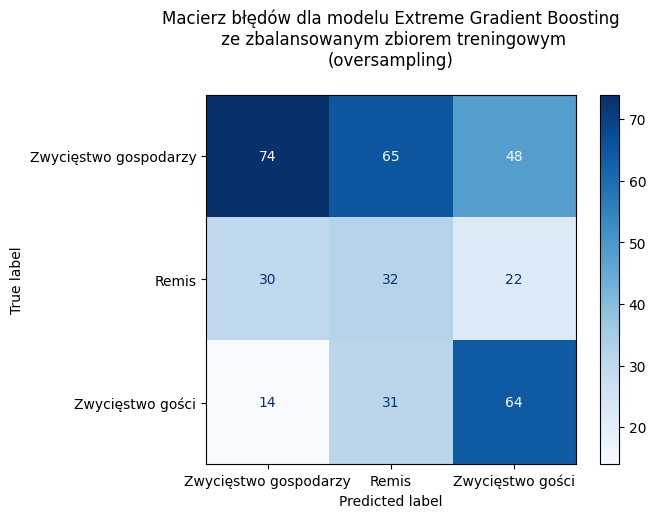

In [66]:
xgb3_test_preds = xgb.predict(X_test)

report = classification_report(y_test, xgb3_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, xgb3_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Extreme Gradient Boosting\n ze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [67]:
X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

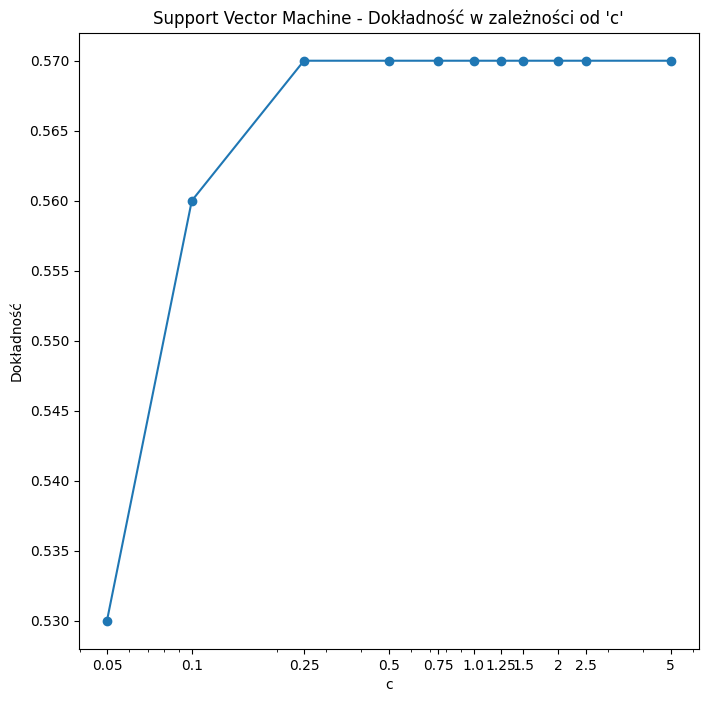

Best accuracy: 0.57; c=0.25


In [68]:
plot_scores_svc = []

cs = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2, 2.5, 5]

for c in cs:
    svc = SVC(kernel='rbf', C=c, random_state=1)
    svc.fit(X_train, y_train)
    test_preds = svc.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_svc.append(score)
 
plt.figure(figsize=(8, 8))
plt.plot(cs, plot_scores_svc, marker='o')
plt.title("Support Vector Machine - Dokładność w zależności od 'c'")
plt.xlabel("c")
plt.ylabel("Dokładność")
plt.xscale('log') 
plt.xticks(cs, cs)
plt.show()

best_accuracy = max(plot_scores_svc)
best_c_svc = cs[plot_scores_svc.index(best_accuracy)]
print(f'Best accuracy: {best_accuracy}; c={best_c_svc}')

In [69]:
svc = SVC(kernel='rbf', C=best_c_svc, random_state=1)
svc.fit(X_train, y_train)

SVC(C=0.25, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.58      0.85      0.69       187
                Remis       0.00      0.00      0.00        84
     Zwycięstwo gości       0.56      0.53      0.54       109

             accuracy                           0.57       380
            macro avg       0.38      0.46      0.41       380
         weighted avg       0.44      0.57      0.49       380



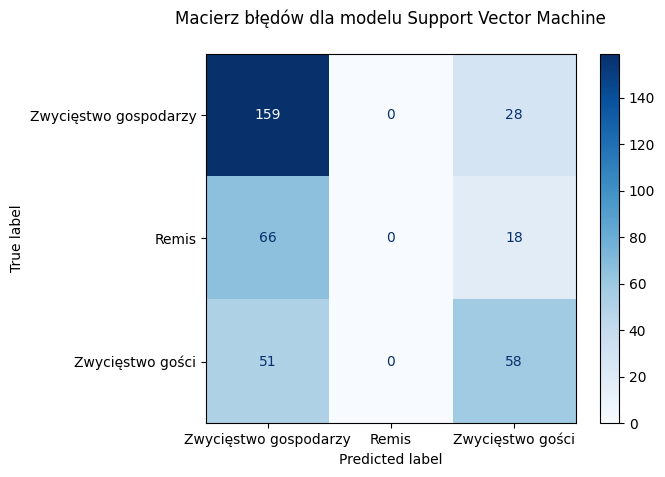

In [70]:
svc_test_preds = svc.predict(X_test)

report = classification_report(y_test, svc_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, svc_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Support Vector Machine\n')
plt.show()

In [71]:
svc_train_preds = svc.predict(X_train)

svc_train_accuracy = accuracy_score(y_train, svc_train_preds)
print(f'SVM Train accuracy: {svc_train_accuracy:.2f}')

SVM Train accuracy: 0.51


***
Proba zastosowania zbalansowangeo zbioru treningowego

In [72]:
X_train = balanced_train_over[predictors]
y_train = balanced_train_over['target']

X_test = test[predictors]
y_test = test['target']

In [73]:
svc.fit(X_train, y_train)

SVC(C=0.25, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.66      0.54      0.59       187
                Remis       0.25      0.23      0.24        84
     Zwycięstwo gości       0.50      0.68      0.57       109

             accuracy                           0.51       380
            macro avg       0.47      0.48      0.47       380
         weighted avg       0.52      0.51      0.51       380



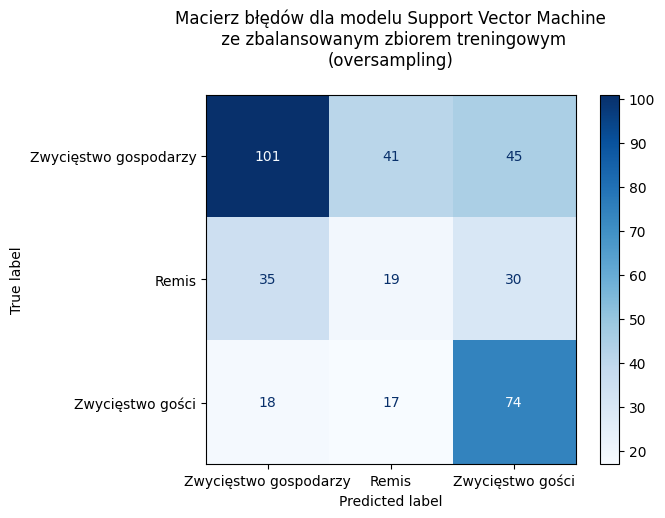

In [74]:
svc2_test_preds = svc.predict(X_test)

report = classification_report(y_test, svc2_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, svc2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Support Vector Machine\n ze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [75]:
X_train = balanced_train_under[predictors]
y_train = balanced_train_under['target']

X_test = test[predictors]
y_test = test['target']

In [76]:
svc.fit(X_train, y_train)

SVC(C=0.25, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.66      0.57      0.61       187
                Remis       0.27      0.25      0.26        84
     Zwycięstwo gości       0.51      0.67      0.58       109

             accuracy                           0.53       380
            macro avg       0.48      0.50      0.49       380
         weighted avg       0.53      0.53      0.53       380



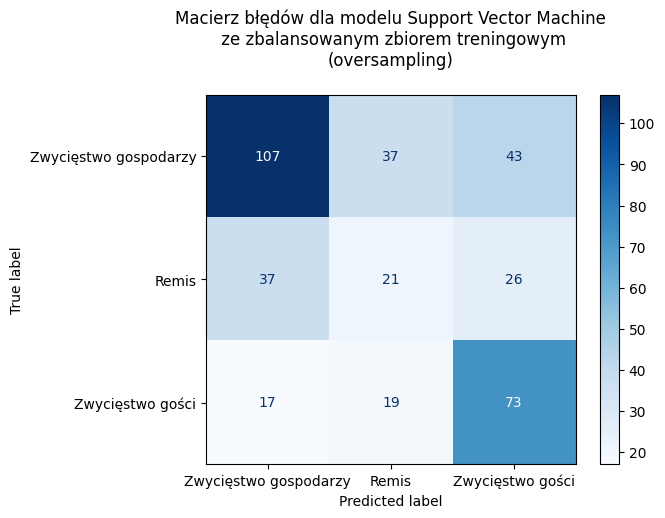

In [77]:
svc3_test_preds = svc.predict(X_test)

report = classification_report(y_test, svc3_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, svc3_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Support Vector Machine\n ze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [78]:
X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

In [79]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [80]:
nn = Sequential()
nn.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(3, activation='softmax'))

In [81]:
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [82]:
nn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50


57/57 [==============================] - 1s 4ms/step - loss: 1.0220 - accuracy: 0.4922 - val_loss: 1.0505 - val_accuracy: 0.4435
Epoch 2/50
57/57 [==============================] - 0s 2ms/step - loss: 0.9862 - accuracy: 0.5238 - val_loss: 1.0474 - val_accuracy: 0.4479
Epoch 3/50
57/57 [==============================] - 0s 2ms/step - loss: 0.9736 - accuracy: 0.5333 - val_loss: 1.0468 - val_accuracy: 0.4545
Epoch 4/50
57/57 [==============================] - 0s 2ms/step - loss: 0.9657 - accuracy: 0.5366 - val_loss: 1.0500 - val_accuracy: 0.4479
Epoch 5/50
57/57 [==============================] - 0s 2ms/step - loss: 0.9589 - accuracy: 0.5349 - val_loss: 1.0512 - val_accuracy: 0.4302
Epoch 6/50
57/57 [==============================] - 0s 2ms/step - loss: 0.9538 - accuracy: 0.5510 - val_loss: 1.0524 - val_accuracy: 0.4279
Epoch 7/50
57/57 [==============================] - 0s 2ms/step - loss: 0.9472 - accuracy: 0.5554 - val_loss: 1.0586 - val_accuracy: 0.4302
Epoch 8/50
57/57 [

In [83]:
nn_test_preds = nn.predict(X_test)
nn_test_preds = np.argmax(nn_test_preds, axis=1)

12/12 [==============================] - 0s 944us/step


                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.58      0.63      0.60       187
                Remis       0.33      0.19      0.24        84
     Zwycięstwo gości       0.48      0.56      0.51       109

             accuracy                           0.51       380
            macro avg       0.46      0.46      0.45       380
         weighted avg       0.50      0.51      0.50       380



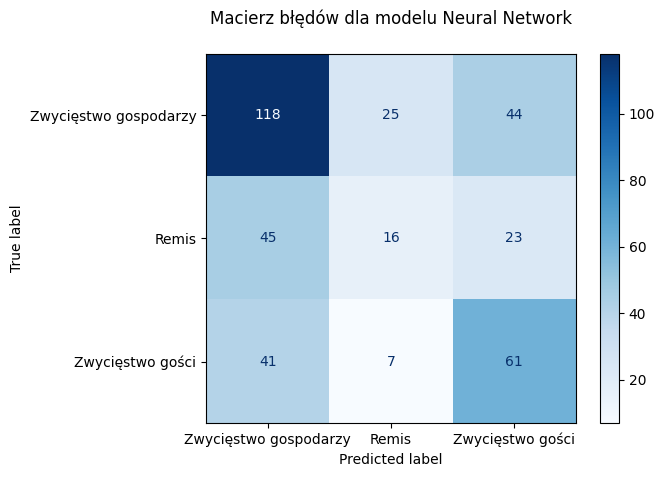

In [84]:
nn_report = classification_report(y_test, nn_test_preds, 
                                  target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(nn_report)

nn_conf_matrix = confusion_matrix(y_test, nn_test_preds, labels=[0, 1, 2])
nn_disp = ConfusionMatrixDisplay(confusion_matrix=nn_conf_matrix, 
                                 display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

nn_disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Neural Network\n')
plt.show()

In [85]:
nn_train_preds = nn.predict(X_train)
nn_train_preds = np.argmax(nn_train_preds, axis=1)

nn_train_accuracy = accuracy_score(y_train, nn_train_preds)
print(f'Neural Network Train accuracy: {nn_train_accuracy:.2f}')

71/71 [==============================] - 0s 892us/step
Neural Network Train accuracy: 0.61


***
Próba zastosowania zbalansowanego zbioru treningowego

In [86]:
X_train = balanced_train_over[predictors]
y_train = balanced_train_over['target']

X_test = test[predictors]
y_test = test['target']

In [87]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [88]:
nn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
77/77 [==============================] - 0s 2ms/step - loss: 0.8115 - accuracy: 0.6420 - val_loss: 1.3952 - val_accuracy: 0.2184
Epoch 2/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7906 - accuracy: 0.6547 - val_loss: 1.4336 - val_accuracy: 0.2447
Epoch 3/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7895 - accuracy: 0.6626 - val_loss: 1.4147 - val_accuracy: 0.2365
Epoch 4/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7670 - accuracy: 0.6753 - val_loss: 1.6838 - val_accuracy: 0.1149
Epoch 5/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7566 - accuracy: 0.6732 - val_loss: 1.4130 - val_accuracy: 0.2447
Epoch 6/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7571 - accuracy: 0.6683 - val_loss: 1.5349 - val_accuracy: 0.1741
Epoch 7/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7436 - accuracy: 0.6745 - val_loss: 1.6597 - val_accuracy: 0.1478
Epoch 8/50
77/77 [==

In [89]:
nn2_test_preds = nn.predict(X_test)
nn2_test_preds = np.argmax(nn2_test_preds, axis=1)

12/12 [==============================] - 0s 1ms/step


                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.62      0.55      0.58       187
                Remis       0.25      0.17      0.20        84
     Zwycięstwo gości       0.42      0.61      0.49       109

             accuracy                           0.48       380
            macro avg       0.43      0.44      0.43       380
         weighted avg       0.48      0.48      0.47       380



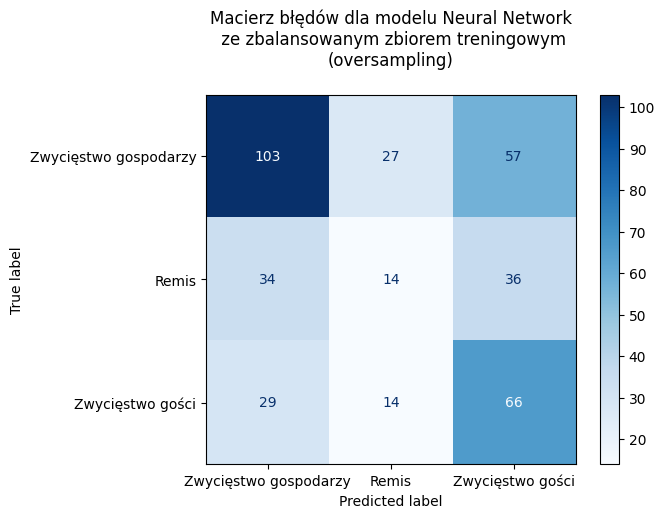

In [90]:
report = classification_report(y_test, nn2_test_preds, 
                                  target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

nn_conf_matrix = confusion_matrix(y_test, nn2_test_preds, labels=[0, 1, 2])
nn_disp = ConfusionMatrixDisplay(confusion_matrix=nn_conf_matrix, 
                                 display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

nn_disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Neural Network\n ze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [91]:
X_train = balanced_train_under[predictors]
y_train = balanced_train_under['target']

X_test = test[predictors]
y_test = test['target']

In [92]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [93]:
nn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
44/44 [==============================] - 0s 3ms/step - loss: 0.8932 - accuracy: 0.6455 - val_loss: 1.5308 - val_accuracy: 0.3971
Epoch 2/50
44/44 [==============================] - 0s 2ms/step - loss: 0.8198 - accuracy: 0.6669 - val_loss: 1.4653 - val_accuracy: 0.3686
Epoch 3/50
44/44 [==============================] - 0s 2ms/step - loss: 0.7897 - accuracy: 0.6719 - val_loss: 1.3041 - val_accuracy: 0.4086
Epoch 4/50
44/44 [==============================] - 0s 2ms/step - loss: 0.7670 - accuracy: 0.6819 - val_loss: 1.3940 - val_accuracy: 0.3600
Epoch 5/50
44/44 [==============================] - 0s 2ms/step - loss: 0.7460 - accuracy: 0.6969 - val_loss: 1.4918 - val_accuracy: 0.3000
Epoch 6/50
44/44 [==============================] - 0s 2ms/step - loss: 0.7357 - accuracy: 0.6955 - val_loss: 1.3781 - val_accuracy: 0.3371
Epoch 7/50
44/44 [==============================] - 0s 2ms/step - loss: 0.7229 - accuracy: 0.7012 - val_loss: 1.5464 - val_accuracy: 0.2800
Epoch 8/50
44/44 [==

In [94]:
nn3_test_preds = nn.predict(X_test)
nn3_test_preds = np.argmax(nn3_test_preds, axis=1)

12/12 [==============================] - 0s 1000us/step


                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.56      0.55      0.55       187
                Remis       0.24      0.12      0.16        84
     Zwycięstwo gości       0.40      0.57      0.47       109

             accuracy                           0.46       380
            macro avg       0.40      0.41      0.39       380
         weighted avg       0.44      0.46      0.44       380



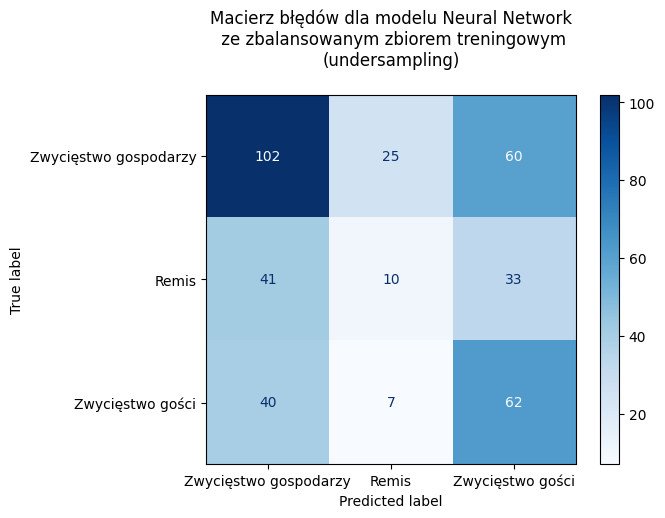

In [95]:
report = classification_report(y_test, nn3_test_preds, 
                                  target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

nn_conf_matrix = confusion_matrix(y_test, nn3_test_preds, labels=[0, 1, 2])
nn_disp = ConfusionMatrixDisplay(confusion_matrix=nn_conf_matrix, 
                                 display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

nn_disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Neural Network\n ze zbalansowanym zbiorem treningowym\n(undersampling)\n')
plt.show()

In [96]:
X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

In [97]:
estimators = [('xgb', xgb), ('knn', knn)]

stacked = StackingClassifier(
    estimators=estimators,
    final_estimator=rf
)
                                   
stacked.fit(X_train, y_train)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              min_samples_split=10, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=3, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('knn', KNeighborsClassifier(n_neighbors=66))],
                   final_estimator=RandomForestClassifier(min_samples_split=10,
                                                          n_estimators=51,
                                                          random_state=1))

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.61      0.70      0.65       187
                Remis       0.23      0.12      0.16        84
     Zwycięstwo gości       0.47      0.52      0.50       109

             accuracy                           0.52       380
            macro avg       0.44      0.45      0.43       380
         weighted avg       0.48      0.52      0.50       380



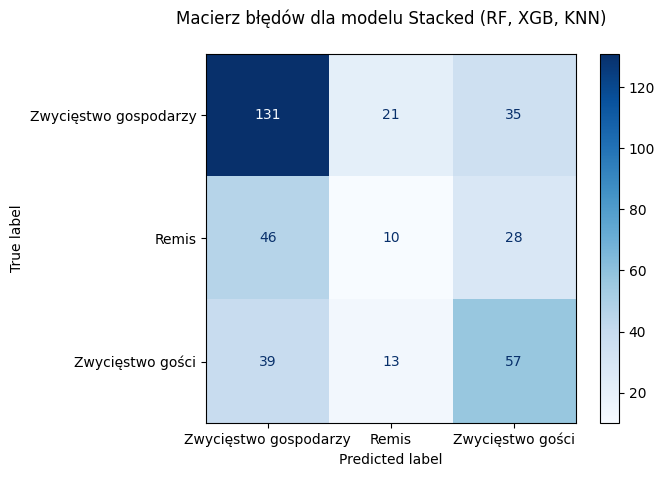

In [98]:
stacked_test_preds = stacked.predict(X_test)

report = classification_report(y_test, stacked_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, stacked_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Stacked (RF, XGB, KNN)\n')
plt.show()

In [99]:
sets = {f'trained_on_{i}_seasons': [] for i in range(1,11)}

for i in range(1,11):
    training_sets = []
    test_sets = []
    
    for j in range(0,10):
        if i == 1:
            training_sets.append(df[(df['season'] == 2010+j)])
            test_sets.append(df[df['season'] == 2011+j])
            
        elif i == 2:
            training_sets.append(df[(df['season'] >= 2009+j) & (df['season'] <= 2010+j)])
            test_sets.append(df[df['season'] == 2011+j])
            
        elif i == 3:
            training_sets.append(df[(df['season'] >= 2008+j) & (df['season'] <= 2010+j)])
            test_sets.append(df[df['season'] == 2011+j])
            
        elif i == 4:
            training_sets.append(df[(df['season'] >= 2007+j) & (df['season'] <= 2010+j)])
            test_sets.append(df[df['season'] == 2011+j])
            
        elif i == 5:
            training_sets.append(df[(df['season'] >= 2006+j) & (df['season'] <= 2010+j)])
            test_sets.append(df[df['season'] == 2011+j])
            
        elif i == 6:
            training_sets.append(df[(df['season'] >= 2005+j) & (df['season'] <= 2010+j)])
            test_sets.append(df[df['season'] == 2011+j])
            
        elif i == 7:
            training_sets.append(df[(df['season'] >= 2004+j) & (df['season'] <= 2010+j)])
            test_sets.append(df[df['season'] == 2011+j])
            
        elif i == 8:
            training_sets.append(df[(df['season'] >= 2003+j) & (df['season'] <= 2010+j)])
            test_sets.append(df[df['season'] == 2011+j])
            
        elif i == 9:
            training_sets.append(df[(df['season'] >= 2002+j) & (df['season'] <= 2010+j)])
            test_sets.append(df[df['season'] == 2011+j])
        
        elif i == 10:
            training_sets.append(df[(df['season'] >= 2001+j) & (df['season'] <= 2010+j)])
            test_sets.append(df[df['season'] == 2011+j])

    sets[f'trained_on_{i}_seasons'].append(training_sets)
    sets[f'trained_on_{i}_seasons'].append(test_sets)

In [100]:
models = [rf, knn, lr, xgb, svc, nn, stacked]

model_names = {
    'randomforestclassifier': 'Random Forest',
    'kneighborsclassifier': 'K-Nearest Neighbors',
    'logisticregression': 'Logistic Regression',
    'xgbclassifier': 'Extreme Gradient Boosting',
    'svc': 'Support Vector Machine',
    'sequential': 'Neural Network',
    'stackingclassifier': 'Stacked (RF, XGB, KNN)'
}

accuracies_full = {f'trained_on_{i}_seasons': [] for i in range(1,11)}

for key, value in sets.items():
    accuracies = {model_names[model.__class__.__name__.lower()]: [] for model in models}

    for model in models:
        
        i = int(re.findall(r'\d+', key)[0])
        
        print('^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v')
        print(f'Training {model_names[model.__class__.__name__.lower()]} model on {i} season/s\n')
        
        for train, test in zip(value[0], value[1]):

            X_train = train[predictors]
            y_train = train['target']
            
            X_test = test[predictors]
            y_test = test['target']
            
            print(f'Training season/s: {pd.concat([train["season"]]).unique().tolist()}')
            print(f'Test season: {pd.concat([test["season"]]).unique().tolist()}')
            
            if model == nn:
                model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
                preds = model.predict(X_test, verbose=0)
                preds = np.argmax(preds, axis=1)

            else:
                model.fit(X_train, y_train)
                preds = model.predict(X_test)

            accuracy = accuracy_score(y_test, preds)
            accuracies[model_names[model.__class__.__name__.lower()]].append(accuracy)
            
            print(f'Accuracy: {accuracy}\n')
            
    accuracies_full[key].append(accuracies)      

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 1 season/s

Training season/s: [2010]
Test season: [2011]
Accuracy: 0.4864864864864865

Training season/s: [2011]
Test season: [2012]
Accuracy: 0.5

Training season/s: [2012]
Test season: [2013]
Accuracy: 0.5226666666666666

Training season/s: [2013]
Test season: [2014]
Accuracy: 0.5052631578947369

Training season/s: [2014]
Test season: [2015]
Accuracy: 0.464

Training season/s: [2015]
Test season: [2016]
Accuracy: 0.4605263157894737

Training season/s: [2016]
Test season: [2017]
Accuracy: 0.5432432432432432

Training season/s: [2017]
Test season: [2018]
Accuracy: 0.5473684210526316

Training season/s: [2018]
Test season: [2019]
Accuracy: 0.49736842105263157

Training season/s: [2019]
Test season: [2020]
Accuracy: 0.46578947368421053

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training K-Nearest Neighbors model on 1 season/s

Training season/s: [2010]
Test season: [2011]
Accuracy: 0.4702702702702703

Training s

Accuracy: 0.5351351351351351

Training season/s: [2016, 2017]
Test season: [2018]
Accuracy: 0.5789473684210527

Training season/s: [2017, 2018]
Test season: [2019]
Accuracy: 0.5157894736842106

Training season/s: [2018, 2019]
Test season: [2020]
Accuracy: 0.4868421052631579

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Extreme Gradient Boosting model on 2 season/s

Training season/s: [2009, 2010]
Test season: [2011]
Accuracy: 0.4864864864864865

Training season/s: [2010, 2011]
Test season: [2012]
Accuracy: 0.4789473684210526

Training season/s: [2011, 2012]
Test season: [2013]
Accuracy: 0.488

Training season/s: [2012, 2013]
Test season: [2014]
Accuracy: 0.4921052631578947

Training season/s: [2013, 2014]
Test season: [2015]
Accuracy: 0.44533333333333336

Training season/s: [2014, 2015]
Test season: [2016]
Accuracy: 0.5

Training season/s: [2015, 2016]
Test season: [2017]
Accuracy: 0.43513513513513513

Training season/s: [2016, 2017]
Test season: [2018]
Accuracy: 0.5368421052631

Accuracy: 0.5947368421052631

Training season/s: [2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.5105263157894737

Training season/s: [2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4710526315789474

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Neural Network model on 3 season/s

Training season/s: [2008, 2009, 2010]
Test season: [2011]
Accuracy: 0.4972972972972973

Training season/s: [2009, 2010, 2011]
Test season: [2012]
Accuracy: 0.5157894736842106

Training season/s: [2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.4693333333333333

Training season/s: [2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.5

Training season/s: [2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.4053333333333333

Training season/s: [2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.42105263157894735

Training season/s: [2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4594594594594595

Training season/s: [2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.4921052631578947

Training season/

Accuracy: 0.4972972972972973

Training season/s: [2008, 2009, 2010, 2011]
Test season: [2012]
Accuracy: 0.5

Training season/s: [2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.4666666666666667

Training season/s: [2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.5026315789473684

Training season/s: [2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.4106666666666667

Training season/s: [2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.4868421052631579

Training season/s: [2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4702702702702703

Training season/s: [2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5236842105263158

Training season/s: [2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.5

Training season/s: [2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.46842105263157896

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 5 season/s

Training season/s: [2006, 2007, 2008, 2009, 2010]
Test season: [20

Accuracy: 0.5289473684210526

Training season/s: [2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.41842105263157897

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 6 season/s

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010]
Test season: [2011]
Accuracy: 0.4756756756756757

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011]
Test season: [2012]
Accuracy: 0.49736842105263157

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.536

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.5026315789473684

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.448

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5894736842105263

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5081081081081081

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017]
Test seas

Accuracy: 0.5026315789473684

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.5493333333333333

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.5131578947368421

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.464

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5894736842105263

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5162162162162162

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5789473684210527

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.4921052631578947

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4921052631578947

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training K-Nearest Neighbors model on 7 seas

Accuracy: 0.4763157894736842

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.5386666666666666

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.5105263157894737

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.44266666666666665

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5526315789473685

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.518918918918919

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5578947368421052

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.5078947368421053

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.5

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^

Accuracy: 0.5

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.5236842105263158

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4631578947368421

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 9 season/s

Training season/s: [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]
Test season: [2011]
Accuracy: 0.4864864864864865

Training season/s: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]
Test season: [2012]
Accuracy: 0.48157894736842105

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.5493333333333333

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.5210526315789473

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.464

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012

Accuracy: 0.4756756756756757

Training season/s: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]
Test season: [2012]
Accuracy: 0.4842105263157895

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.49866666666666665

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.4789473684210526

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.456

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5108108108108108

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5421052631578948

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.5052631578947369

Train

Accuracy: 0.5026315789473684

Training season/s: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.552

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.47368421052631576

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.45866666666666667

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.531578947368421

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5162162162162162

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.4921052631578947

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.44473684210526315

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 201

In [101]:
data = {}

for season, models in accuracies_full.items():
    for model_data in models:
        for model, accuracies_list in model_data.items():
            data.setdefault(model, []).extend(accuracies_list)

df_accuracies = pd.DataFrame(data).round(2)

df_accuracies

,Random Forest,K-Nearest Neighbors,Logistic Regression,Extreme Gradient Boosting,Support Vector Machine,Neural Network,"Stacked (RF, XGB, KNN)"
0,0.49,0.47,0.49,0.49,0.45,0.45,0.48
1,0.50,0.47,0.52,0.48,0.49,0.42,0.47
2,0.52,0.53,0.53,0.45,0.56,0.46,0.46
3,0.51,0.50,0.51,0.49,0.51,0.47,0.47
4,0.46,0.43,0.45,0.42,0.45,0.40,0.42
...,...,...,...,...,...,...,...
95,0.57,0.57,0.58,0.53,0.57,0.53,0.50
96,0.53,0.53,0.54,0.53,0.55,0.52,0.49
97,0.58,0.59,0.60,0.58,0.60,0.49,0.56
98,0.51,0.53,0.51,0.50,0.51,0.44,0.48


In [102]:
df_accuracies.mean()

Random Forest                0.5103
K-Nearest Neighbors          0.5162
Logistic Regression          0.5263
Extreme Gradient Boosting    0.4995
Support Vector Machine       0.5219
Neural Network               0.4750
Stacked (RF, XGB, KNN)       0.4870
dtype: float64

In [103]:
df_accuracies.max()

Random Forest                0.59
K-Nearest Neighbors          0.62
Logistic Regression          0.61
Extreme Gradient Boosting    0.60
Support Vector Machine       0.60
Neural Network               0.58
Stacked (RF, XGB, KNN)       0.56
dtype: float64

In [104]:
df_accuracies.min()

Random Forest                0.43
K-Nearest Neighbors          0.42
Logistic Regression          0.44
Extreme Gradient Boosting    0.42
Support Vector Machine       0.43
Neural Network               0.39
Stacked (RF, XGB, KNN)       0.39
dtype: float64

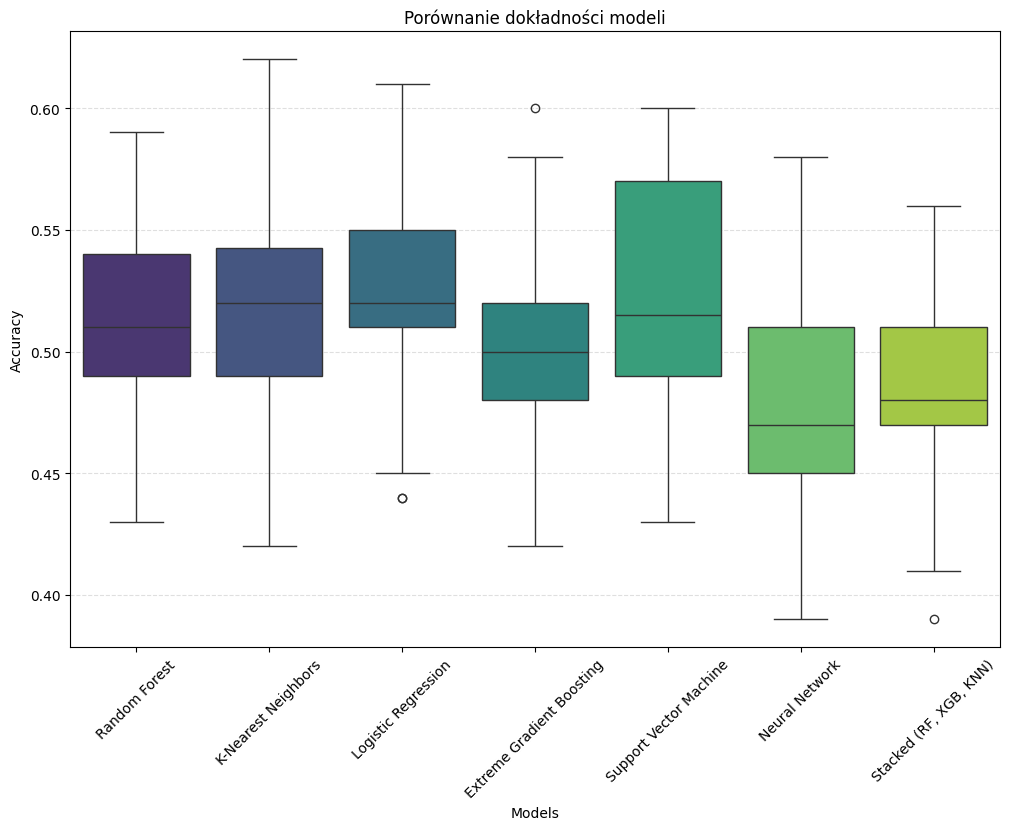

In [105]:
plt.figure(figsize=(12, 8))
boxplot = sns.boxplot(data=df_accuracies, palette='viridis')
plt.title('Porównanie dokładności modeli')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


In [106]:
data = {}

for season, models in accuracies_full.items():
    for model_data in models:
        for model, accuracies_list in model_data.items():
            data.setdefault(model, []).append(np.mean(accuracies_list))

df_accuracies_mean = pd.DataFrame(data).round(3)

df_accuracies_mean

,Random Forest,K-Nearest Neighbors,Logistic Regression,Extreme Gradient Boosting,Support Vector Machine,Neural Network,"Stacked (RF, XGB, KNN)"
0,0.499,0.498,0.514,0.468,0.503,0.436,0.474
1,0.511,0.505,0.519,0.482,0.507,0.442,0.479
2,0.509,0.507,0.524,0.487,0.522,0.469,0.475
3,0.510,0.518,0.526,0.495,0.525,0.476,0.483
4,0.506,0.523,0.530,0.499,0.525,0.474,0.490
5,0.512,0.525,0.529,0.512,0.526,0.484,0.492
6,0.514,0.519,0.529,0.508,0.526,0.479,0.500
7,0.509,0.521,0.529,0.514,0.527,0.495,0.492
8,0.512,0.524,0.531,0.520,0.529,0.496,0.494
9,0.515,0.523,0.530,0.510,0.528,0.498,0.488


In [107]:
df_accuracies_mean = df_accuracies_mean.T
df_accuracies_mean

,0,1,2,3,4,5,6,7,8,9
Random Forest,0.499,0.511,0.509,0.510,0.506,0.512,0.514,0.509,0.512,0.515
K-Nearest Neighbors,0.498,0.505,0.507,0.518,0.523,0.525,0.519,0.521,0.524,0.523
Logistic Regression,0.514,0.519,0.524,0.526,0.530,0.529,0.529,0.529,0.531,0.530
Extreme Gradient Boosting,0.468,0.482,0.487,0.495,0.499,0.512,0.508,0.514,0.520,0.510
Support Vector Machine,0.503,0.507,0.522,0.525,0.525,0.526,0.526,0.527,0.529,0.528
Neural Network,0.436,0.442,0.469,0.476,0.474,0.484,0.479,0.495,0.496,0.498
"Stacked (RF, XGB, KNN)",0.474,0.479,0.475,0.483,0.490,0.492,0.500,0.492,0.494,0.488


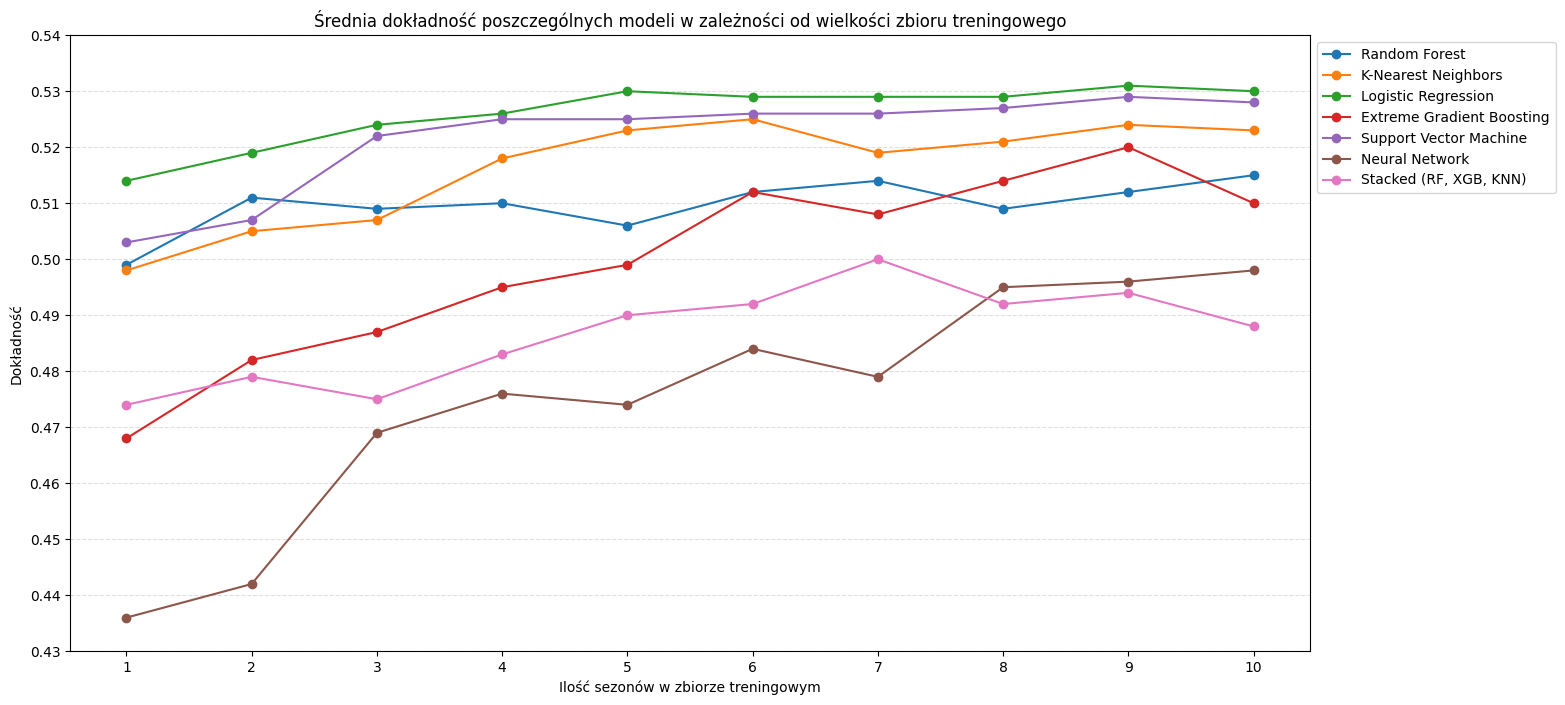

In [157]:
plt.figure(figsize=(16, 8))

for model, accuracies in df_accuracies_mean.iterrows():
    plt.plot(range(1,11), accuracies, marker='o', label=model)

plt.title('Średnia dokładność poszczególnych modeli w zależności od wielkości zbioru treningowego')
plt.xlabel('Ilość sezonów w zbiorze treningowym')
plt.ylabel('Dokładność')
plt.xticks(range(1,11))

min_y = round(df_accuracies_mean.min().min(), 2) - 0.01
max_y = round(df_accuracies_mean.max().max(), 2) + 0.01
    
plt.yticks(np.arange(min_y, max_y , 0.01))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

***
Zbalansowany zbior treningowy (oversampling)

In [109]:
models = [rf, knn, lr, xgb, svc, nn, stacked]

model_names = {
    'randomforestclassifier': 'Random Forest',
    'kneighborsclassifier': 'K-Nearest Neighbors',
    'logisticregression': 'Logistic Regression',
    'xgbclassifier': 'Extreme Gradient Boosting',
    'svc': 'Support Vector Machine',
    'sequential': 'Neural Network',
    'stackingclassifier': 'Stacked (RF, XGB, KNN)'
}

accuracies_full = {f'trained_on_{i}_seasons': [] for i in range(1,11)}

for key, value in sets.items():
    accuracies = {model_names[model.__class__.__name__.lower()]: [] for model in models}

    for model in models:
        
        i = int(re.findall(r'\d+', key)[0])
        
        print('^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v')
        print(f'Training {model_names[model.__class__.__name__.lower()]} model on {i} season/s\n')
        
        for train, test in zip(value[0], value[1]):
            
            class_counts = train['FTR'].value_counts()
            majority_class = class_counts.idxmax()

            balanced_train = pd.concat([
                resample(train[train['FTR'] == cls], 
                         replace=True,
                         n_samples=class_counts[majority_class],
                         random_state=42)
                for cls in class_counts.index
            ])

            X_train = balanced_train[predictors]
            y_train = balanced_train['target']
            
            X_test = test[predictors]
            y_test = test['target']
            
            print(f'Training season/s: {pd.concat([train["season"]]).unique().tolist()}')
            print(f'Test season: {pd.concat([test["season"]]).unique().tolist()}')
            
            if model == nn:
                model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
                preds = model.predict(X_test, verbose=0)
                preds = np.argmax(preds, axis=1)

            else:
                model.fit(X_train, y_train)
                preds = model.predict(X_test)

            accuracy = accuracy_score(y_test, preds)
            accuracies[model_names[model.__class__.__name__.lower()]].append(accuracy)
            
            print(f'Accuracy: {accuracy}\n')
            
    accuracies_full[key].append(accuracies)      

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 1 season/s

Training season/s: [2010]
Test season: [2011]
Accuracy: 0.4918918918918919

Training season/s: [2011]
Test season: [2012]
Accuracy: 0.48157894736842105

Training season/s: [2012]
Test season: [2013]
Accuracy: 0.4746666666666667

Training season/s: [2013]
Test season: [2014]
Accuracy: 0.4631578947368421

Training season/s: [2014]
Test season: [2015]
Accuracy: 0.44266666666666665

Training season/s: [2015]
Test season: [2016]
Accuracy: 0.4710526315789474

Training season/s: [2016]
Test season: [2017]
Accuracy: 0.5

Training season/s: [2017]
Test season: [2018]
Accuracy: 0.4921052631578947

Training season/s: [2018]
Test season: [2019]
Accuracy: 0.4921052631578947

Training season/s: [2019]
Test season: [2020]
Accuracy: 0.4236842105263158

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training K-Nearest Neighbors model on 1 season/s

Training season/s: [2010]
Test season: [2011]
Accuracy: 0.470270270270270

Training season/s: [2016, 2017]
Test season: [2018]
Accuracy: 0.5342105263157895

Training season/s: [2017, 2018]
Test season: [2019]
Accuracy: 0.48947368421052634

Training season/s: [2018, 2019]
Test season: [2020]
Accuracy: 0.45789473684210524

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Extreme Gradient Boosting model on 2 season/s

Training season/s: [2009, 2010]
Test season: [2011]
Accuracy: 0.44054054054054054

Training season/s: [2010, 2011]
Test season: [2012]
Accuracy: 0.43157894736842106

Training season/s: [2011, 2012]
Test season: [2013]
Accuracy: 0.448

Training season/s: [2012, 2013]
Test season: [2014]
Accuracy: 0.48947368421052634

Training season/s: [2013, 2014]
Test season: [2015]
Accuracy: 0.39466666666666667

Training season/s: [2014, 2015]
Test season: [2016]
Accuracy: 0.39473684210526316

Training season/s: [2015, 2016]
Test season: [2017]
Accuracy: 0.4486486486486487

Training season/s: [2016, 2017]
Test season: [2018]
Accuracy: 0.4842105263157895

Train

Accuracy: 0.432

Training season/s: [2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.4710526315789474

Training season/s: [2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.46216216216216216

Training season/s: [2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5184210526315789

Training season/s: [2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.49736842105263157

Training season/s: [2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4394736842105263

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Neural Network model on 3 season/s

Training season/s: [2008, 2009, 2010]
Test season: [2011]
Accuracy: 0.3675675675675676

Training season/s: [2009, 2010, 2011]
Test season: [2012]
Accuracy: 0.39473684210526316

Training season/s: [2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.36

Training season/s: [2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.45

Training season/s: [2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.4266666666666667

Training season/s: [2013, 2014, 2015]
Te

Accuracy: 0.5052631578947369

Training season/s: [2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.4868421052631579

Training season/s: [2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.48947368421052634

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Stacked (RF, XGB, KNN) model on 4 season/s

Training season/s: [2007, 2008, 2009, 2010]
Test season: [2011]
Accuracy: 0.4810810810810811

Training season/s: [2008, 2009, 2010, 2011]
Test season: [2012]
Accuracy: 0.45263157894736844

Training season/s: [2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.49333333333333335

Training season/s: [2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.4263157894736842

Training season/s: [2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.4

Training season/s: [2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.4710526315789474

Training season/s: [2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4864864864864865

Training season/s: [2014, 2015, 2016, 20

Accuracy: 0.45263157894736844

Training season/s: [2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.38666666666666666

Training season/s: [2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.46842105263157896

Training season/s: [2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5135135135135135

Training season/s: [2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.4394736842105263

Training season/s: [2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.4473684210526316

Training season/s: [2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4263157894736842

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 6 season/s

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010]
Test season: [2011]
Accuracy: 0.44594594594594594

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011]
Test season: [2012]
Accuracy: 0.4605263157894737

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012]
Test season

Accuracy: 0.42702702702702705

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.47368421052631576

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.4394736842105263

Training season/s: [2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4263157894736842

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 7 season/s

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010]
Test season: [2011]
Accuracy: 0.4837837837837838

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011]
Test season: [2012]
Accuracy: 0.4763157894736842

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.49866666666666665

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.49736842105263157

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.4826666666666667

T

Accuracy: 0.42133333333333334

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.45526315789473687

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5054054054054054

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.49473684210526314

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.41842105263157897

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4342105263157895

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 8 season/s

Training season/s: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]
Test season: [2011]
Accuracy: 0.45135135135135135

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]
Test season: [2012]
Accuracy: 0.4263157894736842

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [

Accuracy: 0.44594594594594594

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]
Test season: [2012]
Accuracy: 0.4473684210526316

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.448

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.41842105263157897

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.43466666666666665

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.45263157894736844

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4837837837837838

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.49473684210526314

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.45263157894736844

Training season/s: [2012, 2013, 2

Accuracy: 0.49473684210526314

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.4613333333333333

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5131578947368421

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5108108108108108

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5736842105263158

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.5105263157894737

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4921052631578947

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Stacked (RF, XGB, KNN) model on 9 season/s

Training season/s: [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]
Test season: [2011]
Accuracy: 0.4540540540540541

Train

Accuracy: 0.4789473684210526

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.4266666666666667

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5131578947368421

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4945945945945946

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5447368421052632

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.4710526315789474

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.45263157894736844

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Neural Network model on 10 season/s

Training season/s: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]
Test season: [2011]


In [110]:
data = {}

for season, models in accuracies_full.items():
    for model_data in models:
        for model, accuracies_list in model_data.items():
            data.setdefault(model, []).extend(accuracies_list)

df_oversampling_accuracies = pd.DataFrame(data).round(2)

df_oversampling_accuracies

,Random Forest,K-Nearest Neighbors,Logistic Regression,Extreme Gradient Boosting,Support Vector Machine,Neural Network,"Stacked (RF, XGB, KNN)"
0,0.49,0.47,0.49,0.40,0.46,0.61,0.40
1,0.48,0.46,0.48,0.46,0.47,0.51,0.45
2,0.47,0.46,0.50,0.43,0.49,0.53,0.43
3,0.46,0.46,0.46,0.40,0.43,0.50,0.38
4,0.44,0.42,0.43,0.43,0.41,0.42,0.41
...,...,...,...,...,...,...,...
95,0.51,0.48,0.51,0.47,0.51,0.55,0.43
96,0.52,0.46,0.53,0.49,0.49,0.50,0.45
97,0.49,0.52,0.53,0.53,0.54,0.56,0.49
98,0.48,0.43,0.48,0.45,0.47,0.51,0.42


In [111]:
df_oversampling_accuracies.mean()

Random Forest                0.4785
K-Nearest Neighbors          0.4532
Logistic Regression          0.4959
Extreme Gradient Boosting    0.4533
Support Vector Machine       0.4812
Neural Network               0.4871
Stacked (RF, XGB, KNN)       0.4406
dtype: float64

In [112]:
df_oversampling_accuracies.max()

Random Forest                0.56
K-Nearest Neighbors          0.53
Logistic Regression          0.57
Extreme Gradient Boosting    0.54
Support Vector Machine       0.56
Neural Network               0.61
Stacked (RF, XGB, KNN)       0.51
dtype: float64

In [113]:
df_oversampling_accuracies.min()

Random Forest                0.41
K-Nearest Neighbors          0.39
Logistic Regression          0.43
Extreme Gradient Boosting    0.38
Support Vector Machine       0.41
Neural Network               0.36
Stacked (RF, XGB, KNN)       0.37
dtype: float64

In [114]:
data = {}

for season, models in accuracies_full.items():
    for model_data in models:
        for model, accuracies_list in model_data.items():
            data.setdefault(model, []).append(np.mean(accuracies_list))

df_oversampling_accuracies_mean = pd.DataFrame(data).round(3)

df_oversampling_accuracies_mean

,Random Forest,K-Nearest Neighbors,Logistic Regression,Extreme Gradient Boosting,Support Vector Machine,Neural Network,"Stacked (RF, XGB, KNN)"
0,0.473,0.445,0.483,0.422,0.463,0.485,0.422
1,0.478,0.434,0.492,0.441,0.466,0.473,0.435
2,0.479,0.442,0.494,0.443,0.476,0.430,0.428
3,0.480,0.463,0.502,0.470,0.491,0.446,0.458
4,0.478,0.468,0.497,0.462,0.487,0.481,0.448
5,0.478,0.457,0.498,0.452,0.485,0.510,0.438
6,0.496,0.454,0.503,0.460,0.482,0.511,0.453
7,0.473,0.462,0.499,0.463,0.489,0.510,0.451
8,0.476,0.456,0.497,0.452,0.490,0.510,0.434
9,0.477,0.457,0.499,0.468,0.486,0.518,0.442


In [115]:
df_oversampling_accuracies_mean = df_oversampling_accuracies_mean.T
df_oversampling_accuracies_mean

,0,1,2,3,4,5,6,7,8,9
Random Forest,0.473,0.478,0.479,0.480,0.478,0.478,0.496,0.473,0.476,0.477
K-Nearest Neighbors,0.445,0.434,0.442,0.463,0.468,0.457,0.454,0.462,0.456,0.457
Logistic Regression,0.483,0.492,0.494,0.502,0.497,0.498,0.503,0.499,0.497,0.499
Extreme Gradient Boosting,0.422,0.441,0.443,0.470,0.462,0.452,0.460,0.463,0.452,0.468
Support Vector Machine,0.463,0.466,0.476,0.491,0.487,0.485,0.482,0.489,0.490,0.486
Neural Network,0.485,0.473,0.430,0.446,0.481,0.510,0.511,0.510,0.510,0.518
"Stacked (RF, XGB, KNN)",0.422,0.435,0.428,0.458,0.448,0.438,0.453,0.451,0.434,0.442


***
Zbalansowany zbior treningowy (undersampling)

In [116]:
models = [rf, knn, lr, xgb, svc, nn, stacked]

model_names = {
    'randomforestclassifier': 'Random Forest',
    'kneighborsclassifier': 'K-Nearest Neighbors',
    'logisticregression': 'Logistic Regression',
    'xgbclassifier': 'Extreme Gradient Boosting',
    'svc': 'Support Vector Machine',
    'sequential': 'Neural Network',
    'stackingclassifier': 'Stacked (RF, XGB, KNN)'
}

accuracies_full = {f'trained_on_{i}_seasons': [] for i in range(1,11)}

for key, value in sets.items():
    accuracies = {model_names[model.__class__.__name__.lower()]: [] for model in models}

    for model in models:
        
        i = int(re.findall(r'\d+', key)[0])
        
        print('^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v')
        print(f'Training {model_names[model.__class__.__name__.lower()]} model on {i} season/s\n')
        
        for train, test in zip(value[0], value[1]):
            
            class_counts = train['FTR'].value_counts()
            minority_class = class_counts.idxmin()

            balanced_train = pd.concat([
                resample(train[train['FTR'] == cls], 
                         replace=False,
                         n_samples=class_counts[minority_class],
                         random_state=42)
                for cls in class_counts.index
            ])

            X_train = balanced_train[predictors]
            y_train = balanced_train['target']
            
            X_test = test[predictors]
            y_test = test['target']
            
            print(f'Training season/s: {pd.concat([train["season"]]).unique().tolist()}')
            print(f'Test season: {pd.concat([test["season"]]).unique().tolist()}')
            
            if model == nn:
                model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
                preds = model.predict(X_test, verbose=0)
                preds = np.argmax(preds, axis=1)

            else:
                model.fit(X_train, y_train)
                preds = model.predict(X_test)

            accuracy = accuracy_score(y_test, preds)
            accuracies[model_names[model.__class__.__name__.lower()]].append(accuracy)
            
            print(f'Accuracy: {accuracy}\n')
            
    accuracies_full[key].append(accuracies)      

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 1 season/s

Training season/s: [2010]
Test season: [2011]
Accuracy: 0.4702702702702703

Training season/s: [2011]
Test season: [2012]
Accuracy: 0.4342105263157895

Training season/s: [2012]
Test season: [2013]
Accuracy: 0.49866666666666665

Training season/s: [2013]
Test season: [2014]
Accuracy: 0.49736842105263157

Training season/s: [2014]
Test season: [2015]
Accuracy: 0.43733333333333335

Training season/s: [2015]
Test season: [2016]
Accuracy: 0.4394736842105263

Training season/s: [2016]
Test season: [2017]
Accuracy: 0.46216216216216216

Training season/s: [2017]
Test season: [2018]
Accuracy: 0.4921052631578947

Training season/s: [2018]
Test season: [2019]
Accuracy: 0.4473684210526316

Training season/s: [2019]
Test season: [2020]
Accuracy: 0.4368421052631579

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training K-Nearest Neighbors model on 1 season/s

Training season/s: [2010]
Test season: [2011]
Accuracy: 

Accuracy: 0.5421052631578948

Training season/s: [2017, 2018]
Test season: [2019]
Accuracy: 0.5052631578947369

Training season/s: [2018, 2019]
Test season: [2020]
Accuracy: 0.4710526315789474

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Extreme Gradient Boosting model on 2 season/s

Training season/s: [2009, 2010]
Test season: [2011]
Accuracy: 0.4702702702702703

Training season/s: [2010, 2011]
Test season: [2012]
Accuracy: 0.4394736842105263

Training season/s: [2011, 2012]
Test season: [2013]
Accuracy: 0.5226666666666666

Training season/s: [2012, 2013]
Test season: [2014]
Accuracy: 0.4763157894736842

Training season/s: [2013, 2014]
Test season: [2015]
Accuracy: 0.432

Training season/s: [2014, 2015]
Test season: [2016]
Accuracy: 0.41842105263157897

Training season/s: [2015, 2016]
Test season: [2017]
Accuracy: 0.43513513513513513

Training season/s: [2016, 2017]
Test season: [2018]
Accuracy: 0.4763157894736842

Training season/s: [2017, 2018]
Test season: [2019]
Accuracy: 

Accuracy: 0.5394736842105263

Training season/s: [2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.46842105263157896

Training season/s: [2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4105263157894737

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Neural Network model on 3 season/s

Training season/s: [2008, 2009, 2010]
Test season: [2011]
Accuracy: 0.41081081081081083

Training season/s: [2009, 2010, 2011]
Test season: [2012]
Accuracy: 0.43157894736842106

Training season/s: [2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.39466666666666667

Training season/s: [2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.5105263157894737

Training season/s: [2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.472

Training season/s: [2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5105263157894737

Training season/s: [2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4864864864864865

Training season/s: [2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5552631578947368

Training se

Accuracy: 0.5157894736842106

Training season/s: [2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4789473684210526

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Stacked (RF, XGB, KNN) model on 4 season/s

Training season/s: [2007, 2008, 2009, 2010]
Test season: [2011]
Accuracy: 0.43783783783783786

Training season/s: [2008, 2009, 2010, 2011]
Test season: [2012]
Accuracy: 0.4368421052631579

Training season/s: [2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.44266666666666665

Training season/s: [2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.40789473684210525

Training season/s: [2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.35733333333333334

Training season/s: [2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.42894736842105263

Training season/s: [2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.44324324324324327

Training season/s: [2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.45

Training season/s: [2015, 2016, 2017

Accuracy: 0.3893333333333333

Training season/s: [2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.3973684210526316

Training season/s: [2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.46216216216216216

Training season/s: [2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.4368421052631579

Training season/s: [2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.4421052631578947

Training season/s: [2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4473684210526316

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 6 season/s

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010]
Test season: [2011]
Accuracy: 0.4540540540540541

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011]
Test season: [2012]
Accuracy: 0.45789473684210524

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.472

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]


Accuracy: 0.4631578947368421

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.45

Training season/s: [2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4368421052631579

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 7 season/s

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010]
Test season: [2011]
Accuracy: 0.4189189189189189

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011]
Test season: [2012]
Accuracy: 0.4631578947368421

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.5013333333333333

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.4710526315789474

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.3973333333333333

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.48947368421052634

Training sea

Accuracy: 0.4918918918918919

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.46578947368421053

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.4368421052631579

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4131578947368421

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 8 season/s

Training season/s: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]
Test season: [2011]
Accuracy: 0.4756756756756757

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]
Test season: [2012]
Accuracy: 0.4368421052631579

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.49066666666666664

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.4763157894736842

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test 

Accuracy: 0.4394736842105263

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.48

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.45263157894736844

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.42933333333333334

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.45789473684210524

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4864864864864865

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.49473684210526314

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.4026315789473684

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.42894736842105263

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^

Accuracy: 0.464

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5368421052631579

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5054054054054054

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5710526315789474

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.47368421052631576

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.5

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Stacked (RF, XGB, KNN) model on 9 season/s

Training season/s: [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]
Test season: [2011]
Accuracy: 0.43513513513513513

Training season/s: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]
Test season: [2012]
Accuracy: 0.4342105263157895

Training season/s: [2004, 2005, 

Accuracy: 0.44

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.518918918918919

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5263157894736842

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.48947368421052634

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4421052631578947

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Neural Network model on 10 season/s

Training season/s: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]
Test season: [2011]
Accuracy: 0.5432432432432432

Training season/s: [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]
Test season: [2012]
Accuracy: 0.5236842105263158



In [117]:
data = {}

for season, models in accuracies_full.items():
    for model_data in models:
        for model, accuracies_list in model_data.items():
            data.setdefault(model, []).extend(accuracies_list)

df_undersampling_accuracies = pd.DataFrame(data).round(2)

df_undersampling_accuracies

,Random Forest,K-Nearest Neighbors,Logistic Regression,Extreme Gradient Boosting,Support Vector Machine,Neural Network,"Stacked (RF, XGB, KNN)"
0,0.47,0.46,0.54,0.45,0.48,0.53,0.43
1,0.43,0.47,0.49,0.40,0.52,0.48,0.39
2,0.50,0.46,0.48,0.45,0.46,0.55,0.42
3,0.50,0.45,0.50,0.44,0.42,0.48,0.40
4,0.44,0.35,0.42,0.40,0.39,0.46,0.40
...,...,...,...,...,...,...,...
95,0.49,0.46,0.53,0.46,0.50,0.57,0.46
96,0.50,0.49,0.52,0.48,0.52,0.53,0.47
97,0.52,0.52,0.54,0.51,0.53,0.59,0.52
98,0.49,0.49,0.48,0.44,0.49,0.49,0.45


In [118]:
df_undersampling_accuracies.mean()

Random Forest                0.4683
K-Nearest Neighbors          0.4642
Logistic Regression          0.4993
Extreme Gradient Boosting    0.4549
Support Vector Machine       0.4813
Neural Network               0.5109
Stacked (RF, XGB, KNN)       0.4409
dtype: float64

In [119]:
df_undersampling_accuracies.max()

Random Forest                0.52
K-Nearest Neighbors          0.53
Logistic Regression          0.56
Extreme Gradient Boosting    0.52
Support Vector Machine       0.55
Neural Network               0.59
Stacked (RF, XGB, KNN)       0.52
dtype: float64

In [120]:
df_undersampling_accuracies.min()

Random Forest                0.40
K-Nearest Neighbors          0.35
Logistic Regression          0.42
Extreme Gradient Boosting    0.39
Support Vector Machine       0.39
Neural Network               0.39
Stacked (RF, XGB, KNN)       0.36
dtype: float64

In [121]:
data = {}

for season, models in accuracies_full.items():
    for model_data in models:
        for model, accuracies_list in model_data.items():
            data.setdefault(model, []).append(np.mean(accuracies_list))

df_undersampling_accuracies_mean = pd.DataFrame(data).round(3)

df_undersampling_accuracies_mean

,Random Forest,K-Nearest Neighbors,Logistic Regression,Extreme Gradient Boosting,Support Vector Machine,Neural Network,"Stacked (RF, XGB, KNN)"
0,0.462,0.443,0.485,0.427,0.455,0.505,0.418
1,0.472,0.449,0.498,0.454,0.471,0.513,0.429
2,0.466,0.451,0.501,0.452,0.476,0.478,0.447
3,0.468,0.461,0.503,0.454,0.480,0.492,0.426
4,0.465,0.467,0.496,0.443,0.478,0.499,0.431
5,0.458,0.471,0.501,0.462,0.495,0.522,0.446
6,0.463,0.474,0.502,0.463,0.491,0.523,0.454
7,0.472,0.478,0.500,0.458,0.486,0.528,0.455
8,0.483,0.470,0.505,0.471,0.491,0.519,0.454
9,0.476,0.480,0.502,0.466,0.489,0.531,0.445


In [122]:
df_undersampling_accuracies_mean = df_undersampling_accuracies_mean.T
df_undersampling_accuracies_mean

,0,1,2,3,4,5,6,7,8,9
Random Forest,0.462,0.472,0.466,0.468,0.465,0.458,0.463,0.472,0.483,0.476
K-Nearest Neighbors,0.443,0.449,0.451,0.461,0.467,0.471,0.474,0.478,0.470,0.480
Logistic Regression,0.485,0.498,0.501,0.503,0.496,0.501,0.502,0.500,0.505,0.502
Extreme Gradient Boosting,0.427,0.454,0.452,0.454,0.443,0.462,0.463,0.458,0.471,0.466
Support Vector Machine,0.455,0.471,0.476,0.480,0.478,0.495,0.491,0.486,0.491,0.489
Neural Network,0.505,0.513,0.478,0.492,0.499,0.522,0.523,0.528,0.519,0.531
"Stacked (RF, XGB, KNN)",0.418,0.429,0.447,0.426,0.431,0.446,0.454,0.455,0.454,0.445


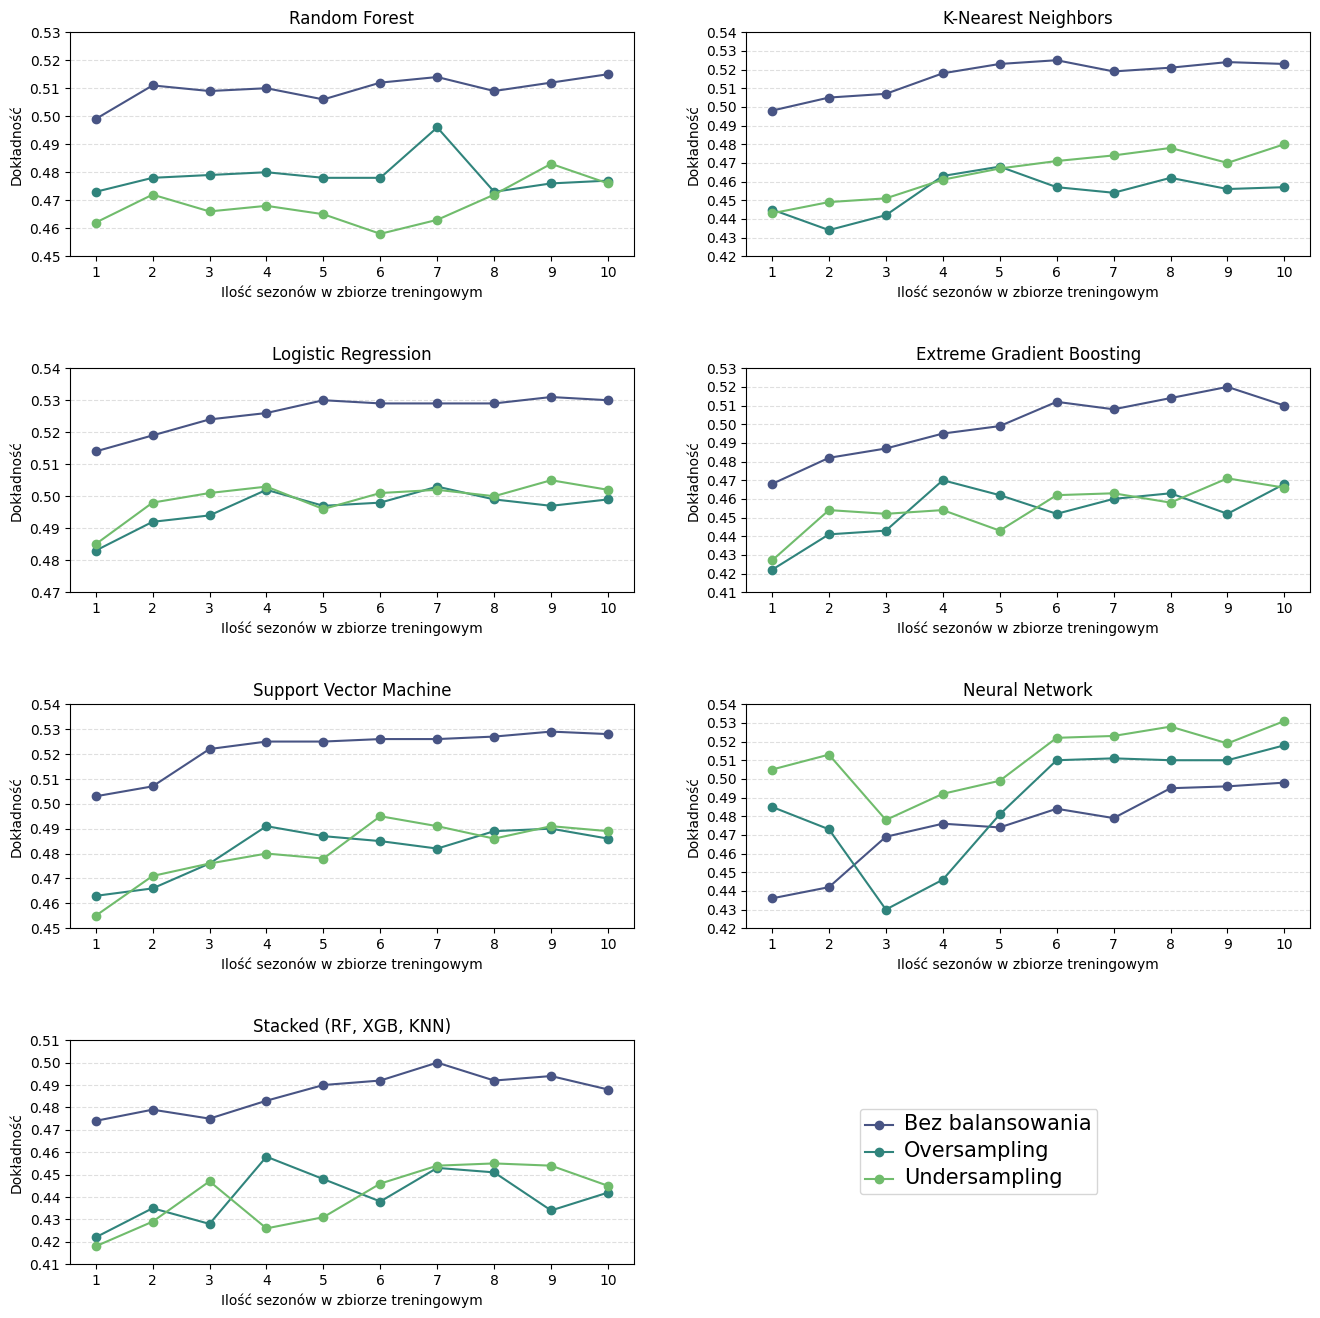

In [156]:
models = [
    'Random Forest', 'K-Nearest Neighbors', 'Logistic Regression', 'Extreme Gradient Boosting', 
    'Support Vector Machine', 'Neural Network', 'Stacked (RF, XGB, KNN)'
]

colors = ['#485484', '#30847c', '#70bc6c']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16) , gridspec_kw={'hspace': 0.5})

for i, model in enumerate(models):
    row = i // 2
    col = i % 2
    
    plt.sca(axes[row, col])
    
    accuracies = df_accuracies_mean.loc[model]
    oversampling_accuracies = df_oversampling_accuracies_mean.loc[model]
    undersampling_accuracies = df_undersampling_accuracies_mean.loc[model]
    
    plt.plot(range(1, 11), accuracies, marker='o', label='Bez balansowania', color=colors[0])
    plt.plot(range(1, 11), oversampling_accuracies, marker='o', label='Oversampling', color=colors[1])
    plt.plot(range(1, 11), undersampling_accuracies, marker='o', label='Undersampling', color=colors[2])
    
    merged = []
    merged.extend(accuracies)
    merged.extend(oversampling_accuracies)
    merged.extend(undersampling_accuracies)
    
    min_y = round(min(merged), 2) - 0.01
    max_y = round(max(merged), 2) + 0.01
    
    plt.title(model)
    plt.xlabel('Ilość sezonów w zbiorze treningowym')
    plt.ylabel('Dokładność')
    plt.xticks(range(1, 11))
    plt.yticks(np.arange(min_y, max_y, 0.01))
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    
axes[3, 1].remove()
plt.sca(axes[-1, -2])
legend = plt.legend(bbox_to_anchor=(1.835, 0.725))
for text in legend.get_texts():
    text.set_fontsize(15)

plt.tight_layout()
plt.show()

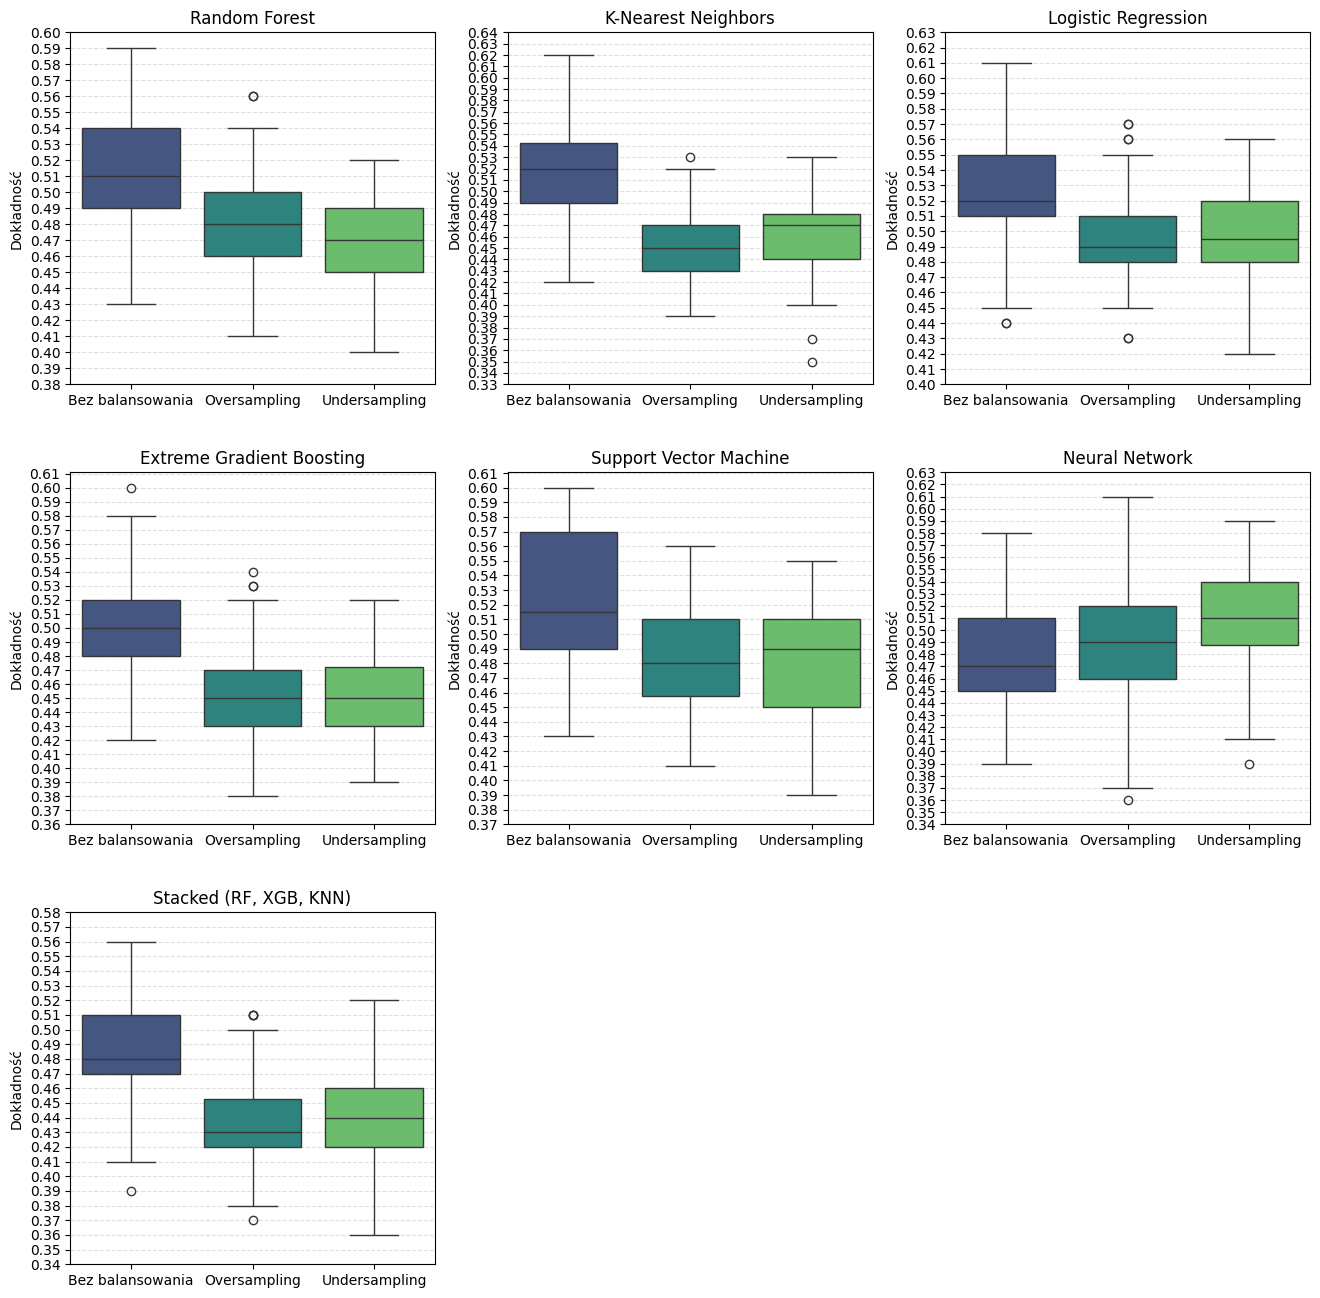

In [137]:
models = [
    'Random Forest', 'K-Nearest Neighbors', 'Logistic Regression', 'Extreme Gradient Boosting', 
    'Support Vector Machine', 'Neural Network', 'Stacked (RF, XGB, KNN)'
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 16) , gridspec_kw={'hspace': 0.25})

for i, model in enumerate(models):
    row = i // 3
    col = i % 3
    
    data = pd.concat([
        df_accuracies[model], 
        df_oversampling_accuracies[model], 
        df_undersampling_accuracies[model]
    ], axis=1, keys=['Bez balansowania', 'Oversampling', 'Undersampling'])
    
    min_y = round(data.min().min(), 2) - 0.02
    max_y = round(data.max().max(), 2) + 0.02
    
    sns.boxplot(data=data, ax=axes[row, col], palette='viridis')
    axes[row, col].set_title(model)
    axes[row, col].set_ylabel('Dokładność')
    axes[row, col].set_xticklabels(['Bez balansowania', 'Oversampling', 'Undersampling'])
    axes[row, col].set_yticks(np.arange(min_y, max_y, 0.01))
    axes[row, col].grid(axis='y', linestyle='--', alpha=0.4)
    
axes[2, 1].remove()
axes[2, 2].remove()

plt.tight_layout()
plt.show()